In [1]:
!nvidia-smi

Sun Feb 25 19:06:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   38C    P8              21W / 215W |    550MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [8]:
np.save(f'{data_dir}esd.audio16k.train.npy', 
        np.array(x_train, dtype=object), allow_pickle=True)
np.save(f'{data_dir}esd.audio16k.test.npy', 
        np.array(x_test, dtype=object), allow_pickle=True)
np.save(f'{data_dir}esd.label_emotion.train.npy', 
        np.array(y_train, dtype=object), allow_pickle=True)
np.save(f'{data_dir}esd.label_emotion.test.npy', 
        np.array(y_test, dtype=object), allow_pickle=True)

In [9]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [10]:
np.unique(y_test)

array(['anger', 'hapiness', 'neutral', 'sadness'], dtype='<U8')

In [11]:
labels = ['ang', 'neu', 'sad', 'hap']

In [12]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
import traceback

In [14]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(160, 32, batch_first=True)
    (pad_layer)

In [15]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                        | 0.0005714285714285715/10 [00:00<3:46:04, 1356.56s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.499211
Mem before-during-after: 3254784 3496596992 36363776


  0%|                          | 0.023428571428571413/10 [00:15<2:02:02, 733.98s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.454902
Mem before-during-after: 37138432 3514867200 37138432


  0%|                          | 0.046285714285714215/10 [00:31<2:07:01, 765.74s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.302741
Mem before-during-after: 37138432 3515327488 36363776


  1%|▏                          | 0.06914285714285702/10 [00:46<2:10:30, 788.51s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.355951
Mem before-during-after: 37271552 3514867200 36363776


  1%|▏                          | 0.09199999999999982/10 [01:01<2:01:45, 737.34s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.492739
Mem before-during-after: 36363776 3514948096 37279232


  1%|▎                          | 0.11485714285714262/10 [01:16<1:54:38, 695.86s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.760175
Mem before-during-after: 38053888 3515782656 38053888


  1%|▎                          | 0.13771428571428573/10 [01:31<1:52:33, 684.83s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.146697
Mem before-during-after: 37582336 3196485120 36363776


  2%|▍                           | 0.1605714285714291/10 [01:47<1:58:32, 722.89s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.176046
Mem before-during-after: 36363776 3515782656 37219328


  2%|▍                          | 0.18342857142857244/10 [02:02<1:54:33, 700.22s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 0.979152
Mem before-during-after: 37219328 3516406272 37219328


  2%|▌                           | 0.2062857142857158/10 [02:17<1:49:20, 669.88s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.223064
Mem before-during-after: 37352448 3064896512 36435456


  2%|▌                          | 0.22914285714285915/10 [02:32<1:49:24, 671.88s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.206705
Mem before-during-after: 37337600 3515246592 36809216


  3%|▋                           | 0.2520000000000024/10 [02:47<1:44:45, 644.75s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.713105
Mem before-during-after: 37300736 3427169280 37324288


  3%|▋                          | 0.27485714285714463/10 [03:02<1:54:40, 707.47s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 0.967904
Mem before-during-after: 38053888 3516406272 38053888


  3%|▊                          | 0.29828571428571543/10 [03:17<1:37:30, 603.02s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.126138
Mem before-during-after: 37258752 3515871744 37279232


  3%|▉                           | 0.3205714285714291/10 [03:32<1:57:26, 728.03s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 1.146181
Mem before-during-after: 37324288 3515000320 37271552


  3%|▉                          | 0.34342857142857136/10 [03:47<1:44:26, 648.93s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.533510
Mem before-during-after: 37133312 3516406272 37138432


  4%|█                           | 0.3662857142857136/10 [04:01<1:52:04, 697.97s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.226788
Mem before-during-after: 38053888 3515782656 38053888


  4%|█                          | 0.38914285714285585/10 [04:16<1:49:20, 682.60s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.583397
Mem before-during-after: 37082112 3515701248 37138432


  4%|█▏                          | 0.4119999999999981/10 [04:31<1:54:31, 716.68s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 1.394158
Mem before-during-after: 37082112 3516406272 37279232


  4%|█▏                         | 0.43485714285714033/10 [04:46<1:47:32, 674.61s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 1.130779
Mem before-during-after: 36363776 3514356224 36363776


  5%|█▎                          | 0.4577142857142826/10 [05:00<1:46:33, 670.06s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 1.417015
Mem before-during-after: 36363776 3515223040 36363776


  5%|█▎                          | 0.4805714285714248/10 [05:15<1:48:47, 685.75s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 0.991547
Mem before-during-after: 36363776 3512062464 37715456


  5%|█▍                          | 0.5034285714285671/10 [05:30<2:00:20, 760.31s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 1.044918
Mem before-during-after: 36363776 3515782656 36363776


  5%|█▍                          | 0.5262857142857094/10 [05:44<1:50:27, 699.58s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.329763
Mem before-during-after: 37219328 3515782656 37219328


  5%|█▌                          | 0.5491428571428516/10 [05:59<1:46:51, 678.39s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 1.103402
Mem before-during-after: 37279232 3516014080 37390848


  6%|█▌                          | 0.5719999999999938/10 [06:14<1:54:34, 729.20s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 1.143204
Mem before-during-after: 36577792 3514404864 36363776


  6%|█▋                          | 0.5948571428571361/10 [06:28<1:44:32, 666.92s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 1.659717
Mem before-during-after: 36363776 3514683904 36363776


  6%|█▋                          | 0.6182857142857069/10 [06:43<1:32:17, 590.24s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 1.119930
Mem before-during-after: 37352448 3515718656 37352448


  6%|█▊                          | 0.6405714285714206/10 [06:57<1:53:29, 727.53s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 0.982788
Mem before-during-after: 37219328 3515782656 36363776


  7%|█▊                          | 0.6634285714285628/10 [07:12<1:53:04, 726.69s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 1.244209
Mem before-during-after: 37138432 3237408768 36363776


  7%|█▉                          | 0.6862857142857051/10 [07:27<1:51:18, 717.11s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 0.966513
Mem before-during-after: 36748800 3515215872 37431296


  7%|█▉                          | 0.7091428571428473/10 [07:41<1:45:21, 680.38s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 1.169384
Mem before-during-after: 37352448 3514596864 36363776


  7%|██                          | 0.7319999999999895/10 [07:56<1:48:23, 701.70s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 0.915249
Mem before-during-after: 36363776 3514685440 36363776


  8%|██                          | 0.7548571428571318/10 [08:10<1:48:42, 705.46s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 1.040710
Mem before-during-after: 37279232 3515898368 37138432


  8%|██▎                          | 0.777714285714274/10 [08:25<1:47:46, 701.13s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 1.447229
Mem before-during-after: 37219328 3515782656 37219328


 10%|██▉                           | 0.9999999999999823/10 [09:45<50:26, 336.22s/it]


Test Epoch: 1	Accuracy: 2844/5600 (51%)



 10%|██▉                          | 1.000571428571411/10 [09:46<1:00:33, 403.69s/it]

Train Epoch: 2 [0/22400 (0%)]	Loss: 1.516830
Mem before-during-after: 36359680 3515782656 36363776


 10%|██▊                         | 1.0234285714285576/10 [10:01<1:50:42, 739.98s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 1.391418
Mem before-during-after: 37352448 3515718656 37352448


 10%|██▉                         | 1.0462857142857043/10 [10:16<1:46:44, 715.33s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 1.075507
Mem before-during-after: 36613632 3514075136 37082112


 11%|███                          | 1.069142857142851/10 [10:31<1:36:29, 648.29s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 1.235298
Mem before-during-after: 37082112 3444710400 36475392


 11%|███                         | 1.0919999999999976/10 [10:46<1:44:05, 701.11s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 1.411739
Mem before-during-after: 37352448 3515718656 37352448


 11%|███▏                         | 1.115428571428573/10 [11:00<1:24:46, 572.46s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 1.268306
Mem before-during-after: 36577792 3118977024 36363776


 11%|███▎                         | 1.137714285714291/10 [11:14<1:48:01, 731.37s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 1.672854
Mem before-during-after: 36530688 3514126336 36397568


 12%|███▏                        | 1.1605714285714377/10 [11:29<1:43:34, 703.03s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 1.032577
Mem before-during-after: 36727296 3515772416 36562432


 12%|███▎                        | 1.1834285714285844/10 [11:43<1:39:15, 675.46s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 1.335980
Mem before-during-after: 37138432 3354825728 36913664


 12%|███▍                         | 1.206285714285731/10 [11:58<1:38:44, 673.68s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 1.161097
Mem before-during-after: 36363776 3515179520 37812224


 12%|███▍                        | 1.2291428571428777/10 [12:13<1:43:28, 707.87s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 1.258389
Mem before-during-after: 38053888 3515782656 38053888


 13%|███▌                        | 1.2520000000000244/10 [12:27<1:43:11, 707.78s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 0.911811
Mem before-during-after: 36809216 3515063808 37279232


 13%|███▋                         | 1.274857142857171/10 [12:43<1:50:45, 761.65s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.821034
Mem before-during-after: 37219328 3515782656 37219328


 13%|███▋                        | 1.2977142857143178/10 [12:57<1:43:10, 711.34s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 1.884312
Mem before-during-after: 37283328 3515081216 37352448


 13%|███▋                        | 1.3205714285714645/10 [13:12<1:41:57, 704.84s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 0.957819
Mem before-during-after: 37352448 3515718656 37352448


 13%|███▊                        | 1.3434285714286112/10 [13:26<1:43:48, 719.50s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 0.950272
Mem before-during-after: 37271552 3514867200 36363776


 14%|███▊                        | 1.3662857142857578/10 [13:41<1:40:23, 697.73s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 1.112963
Mem before-during-after: 36496896 3515619840 36496896


 14%|███▉                        | 1.3891428571429045/10 [13:56<1:40:58, 703.64s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 1.063613
Mem before-during-after: 37219328 3515782656 37219328


 14%|███▉                        | 1.4125714285714799/10 [14:10<1:23:49, 585.72s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 1.302889
Mem before-during-after: 36411392 3515622400 36363776


 14%|████▏                        | 1.434857142857198/10 [14:24<1:32:45, 649.76s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.814123
Mem before-during-after: 36513280 3515595264 37555712


 15%|████                        | 1.4577142857143446/10 [14:39<1:39:08, 696.41s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 0.883255
Mem before-during-after: 38053888 3516406272 37279232


 15%|████▏                       | 1.4805714285714913/10 [14:53<1:28:30, 623.31s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 1.054854
Mem before-during-after: 36528640 3181495808 36363776


 15%|████▎                        | 1.503428571428638/10 [15:08<1:42:08, 721.31s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 1.483134
Mem before-during-after: 37219328 3515782656 37219328


 15%|████▎                       | 1.5262857142857846/10 [15:22<1:33:42, 663.56s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 1.353419
Mem before-during-after: 36363776 3237707776 36363776


 15%|████▎                       | 1.5491428571429313/10 [15:37<1:41:21, 719.67s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 1.253027
Mem before-during-after: 37219328 3514508800 36363776


 16%|████▌                        | 1.572000000000078/10 [15:52<1:38:33, 701.60s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 0.966053
Mem before-during-after: 37352448 3515081216 37352448


 16%|████▍                       | 1.5948571428572247/10 [16:07<1:38:48, 705.33s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 1.006831
Mem before-during-after: 36363776 3473327616 36969984


 16%|████▌                       | 1.6177142857143714/10 [16:21<1:30:03, 644.62s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 0.991476
Mem before-during-after: 36363776 3514026496 36363776


 16%|████▊                        | 1.640571428571518/10 [16:36<1:33:54, 674.00s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 1.066957
Mem before-during-after: 36363776 3340366848 36363776


 17%|████▋                       | 1.6634285714286647/10 [16:51<1:36:36, 695.29s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.876527
Mem before-during-after: 36363776 3515098624 36496896


 17%|████▋                       | 1.6862857142858114/10 [17:05<1:25:19, 615.74s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 1.042078
Mem before-during-after: 36528640 3225342976 37044224


 17%|████▉                        | 1.709142857142958/10 [17:20<1:35:28, 690.91s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 1.313397
Mem before-during-after: 36363776 3368032256 36366848


 17%|████▊                       | 1.7320000000001048/10 [17:35<1:37:08, 704.95s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 1.181621
Mem before-during-after: 37138432 3515782656 36363776


 18%|████▉                       | 1.7554285714286801/10 [17:49<1:19:35, 579.21s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 1.395900
Mem before-during-after: 37219328 3405428224 36479488


 18%|████▉                       | 1.7777142857143982/10 [18:04<1:33:32, 682.63s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 1.343509
Mem before-during-after: 38165504 3352176640 36363776


 20%|██████                        | 2.0000000000001497/10 [19:24<43:11, 324.00s/it]


Test Epoch: 2	Accuracy: 2760/5600 (49%)



 20%|██████▏                        | 2.000571428571578/10 [19:25<56:00, 420.15s/it]

Train Epoch: 3 [0/22400 (0%)]	Loss: 1.078355
Mem before-during-after: 37275136 3514874880 36363776


 20%|█████▊                       | 2.023428571428716/10 [19:40<1:28:25, 665.11s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 1.062317
Mem before-during-after: 36528640 3515229184 37219328


 20%|█████▋                      | 2.0462857142858537/10 [19:54<1:32:52, 700.56s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 1.107475
Mem before-during-after: 36528640 3515330048 37138432


 21%|█████▊                      | 2.0691428571429915/10 [20:09<1:34:32, 715.22s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 1.041472
Mem before-during-after: 37138432 3515782656 37138432


 21%|█████▊                      | 2.0920000000001293/10 [20:24<1:34:38, 718.09s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 0.922486
Mem before-during-after: 36363776 3514677760 36363776


 21%|██████▏                      | 2.114857142857267/10 [20:39<1:30:27, 688.36s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 1.669494
Mem before-during-after: 37219328 3436866048 37101056


 21%|██████▏                      | 2.137714285714405/10 [20:53<1:25:27, 652.19s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.973192
Mem before-during-after: 36363776 3514548736 36363776


 22%|██████                      | 2.1605714285715427/10 [21:08<1:30:34, 693.25s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.091373
Mem before-during-after: 37352448 3515718656 37352448


 22%|██████                      | 2.1834285714286805/10 [21:22<1:31:03, 698.96s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 0.645899
Mem before-during-after: 37219328 3515782656 37219328


 22%|██████▏                     | 2.2062857142858183/10 [21:36<1:27:01, 670.02s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 1.184598
Mem before-during-after: 36528640 3313606656 36679680


 22%|██████▍                      | 2.229142857142956/10 [21:51<1:33:47, 724.22s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 1.020580
Mem before-during-after: 36363776 3515782656 36774912


 23%|██████▌                      | 2.252000000000094/10 [22:05<1:30:09, 698.21s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 0.732122
Mem before-during-after: 37138432 3514982912 37138432


 23%|██████▎                     | 2.2748571428572317/10 [22:20<1:28:14, 685.33s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 0.910145
Mem before-during-after: 37555712 3516241408 37390848


 23%|██████▍                     | 2.2977142857143695/10 [22:35<1:33:16, 726.56s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.922546
Mem before-during-after: 36363776 3515782656 36363776


 23%|██████▍                     | 2.3205714285715073/10 [22:50<1:29:39, 700.50s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 0.917941
Mem before-during-after: 37219328 3515782656 36363776


 23%|██████▊                      | 2.343428571428645/10 [23:04<1:29:43, 703.12s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 1.005621
Mem before-during-after: 36613632 3515718656 36613632


 24%|██████▊                      | 2.366285714285783/10 [23:19<1:29:29, 703.38s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 1.160711
Mem before-during-after: 36661760 3424257024 36363776


 24%|██████▉                      | 2.389714285714349/10 [23:34<1:14:50, 590.10s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 1.012166
Mem before-during-after: 36432896 3515718656 36432896


 24%|██████▉                      | 2.412571428571487/10 [23:48<1:14:50, 591.87s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.650175
Mem before-during-after: 37219328 3515782656 37219328


 24%|███████                      | 2.435428571428625/10 [24:05<1:27:15, 692.12s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 1.029676
Mem before-during-after: 37352448 3515526144 37352448


 25%|███████▏                     | 2.457714285714334/10 [24:19<1:29:13, 709.85s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 0.788841
Mem before-during-after: 37219328 3515782656 37219328


 25%|███████▏                     | 2.480571428571472/10 [24:34<1:33:04, 742.66s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 1.468780
Mem before-during-after: 36613632 3514867200 36363776


 25%|███████                     | 2.5034285714286098/10 [24:49<1:34:36, 757.15s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 1.022873
Mem before-during-after: 37466112 3515491840 37138432


 25%|███████▎                     | 2.526857142857176/10 [25:04<1:13:23, 589.27s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 1.630070
Mem before-during-after: 36528640 2885899776 36363776


 25%|███████▏                    | 2.5491428571428854/10 [25:19<1:31:37, 737.81s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 1.086773
Mem before-during-after: 37219328 3515782656 37219328


 26%|███████▍                     | 2.572000000000023/10 [25:35<1:28:12, 712.57s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.908479
Mem before-during-after: 37219328 3515782656 37219328


 26%|███████▌                     | 2.594857142857161/10 [25:49<1:25:34, 693.39s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 0.964573
Mem before-during-after: 37316096 3515605504 37138432


 26%|███████▎                    | 2.6177142857142988/10 [26:04<1:27:22, 710.11s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 1.332137
Mem before-during-after: 37352448 3515718656 37352448


 26%|███████▍                    | 2.6405714285714366/10 [26:19<1:27:36, 714.27s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.620871
Mem before-during-after: 37279232 3515898368 37138432


 27%|███████▋                     | 2.664000000000003/10 [26:35<1:21:34, 667.14s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 1.446150
Mem before-during-after: 37404672 3514867200 36363776


 27%|███████▌                    | 2.6868571428571406/10 [26:50<1:17:10, 633.21s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 0.814106
Mem before-during-after: 37352448 3515718656 37352448


 27%|████████▏                     | 2.70914285714285/10 [27:04<1:24:41, 696.92s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 1.087862
Mem before-during-after: 37352448 3515718656 37352448


 27%|███████▋                    | 2.7319999999999878/10 [27:19<1:25:58, 709.77s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 0.736834
Mem before-during-after: 37352448 3515718656 37352448


 28%|███████▋                    | 2.7548571428571256/10 [27:34<1:18:23, 649.18s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 1.384998
Mem before-during-after: 36363776 3428526080 36475392


 28%|███████▊                    | 2.7777142857142634/10 [27:48<1:25:37, 711.31s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 1.270947
Mem before-during-after: 36528640 3515330048 37138432


 30%|████████▉                     | 2.9999999999999285/10 [29:08<37:18, 319.82s/it]


Test Epoch: 3	Accuracy: 3129/5600 (56%)



 30%|█████████▎                     | 3.000571428571357/10 [29:08<45:34, 390.69s/it]

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.941483
Mem before-during-after: 36359680 3515782656 36363776


 30%|████████▍                   | 3.0234285714284947/10 [29:23<1:23:24, 717.35s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 1.469605
Mem before-during-after: 37138432 3514867200 37138432


 30%|████████▊                    | 3.046857142857061/10 [29:38<1:11:30, 617.05s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 0.701379
Mem before-during-after: 36363776 3514660864 36363776


 31%|████████▌                   | 3.0691428571427704/10 [29:52<1:19:51, 691.27s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 1.407486
Mem before-during-after: 37219328 3515782656 37219328


 31%|████████▉                    | 3.091999999999908/10 [30:07<1:20:47, 701.79s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 1.222901
Mem before-during-after: 37352448 3515718656 37352448


 31%|█████████                    | 3.114857142857046/10 [30:21<1:18:39, 685.42s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 1.123777
Mem before-during-after: 36363776 3514787328 36563456


 31%|████████▊                   | 3.1377142857141838/10 [30:36<1:16:50, 671.93s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 1.165440
Mem before-during-after: 37352448 3285111808 36363776


 32%|████████▊                   | 3.1605714285713216/10 [30:51<1:20:18, 704.46s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 1.082761
Mem before-during-after: 36560896 3511830016 36727296


 32%|████████▉                   | 3.1834285714284594/10 [31:05<1:23:45, 737.26s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 1.041229
Mem before-during-after: 36363776 3515782656 36363776


 32%|█████████▎                   | 3.206285714285597/10 [31:19<1:20:47, 713.52s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 1.024511
Mem before-during-after: 37138432 3515063808 37279232


 32%|█████████▎                   | 3.229142857142735/10 [31:34<1:18:43, 697.69s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 0.867731
Mem before-during-after: 37138432 3514867200 37138432


 33%|█████████                   | 3.2519999999998728/10 [31:48<1:18:33, 698.51s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 0.986400
Mem before-during-after: 37720576 3516472832 37555712


 33%|█████████▍                   | 3.275428571428439/10 [32:04<1:14:37, 665.85s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 1.242609
Mem before-during-after: 37352448 3515526144 37352448


 33%|█████████▌                   | 3.298285714285577/10 [32:19<1:06:03, 591.36s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 0.713239
Mem before-during-after: 38165504 3516241408 37390848


 33%|█████████▋                   | 3.320571428571286/10 [32:33<1:12:20, 649.89s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 1.115210
Mem before-during-after: 36363776 3485671936 37293056


 33%|█████████▋                   | 3.343428571428424/10 [32:48<1:17:30, 698.65s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 1.154132
Mem before-during-after: 37352448 3515718656 37352448


 34%|█████████▊                   | 3.366285714285562/10 [33:02<1:16:25, 691.19s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 1.424917
Mem before-during-after: 37138432 3515214336 37390848


 34%|█████████▍                  | 3.3891428571426996/10 [33:17<1:23:31, 758.11s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 1.052169
Mem before-during-after: 37279232 3515782656 38053888


 34%|█████████▌                  | 3.4119999999998374/10 [33:31<1:17:12, 703.12s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 1.177020
Mem before-during-after: 36363776 3515782656 36774912


 34%|█████████▌                  | 3.4354285714284036/10 [33:46<1:05:12, 596.04s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.798613
Mem before-during-after: 37138432 3514867200 37138432


 35%|██████████                   | 3.457714285714113/10 [34:01<1:18:45, 722.35s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 1.242236
Mem before-during-after: 36363776 3513959424 36363776


 35%|██████████                   | 3.480571428571251/10 [34:15<1:16:19, 702.41s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 1.251423
Mem before-during-after: 37138432 3515063808 37279232


 35%|█████████▊                  | 3.5034285714283886/10 [34:30<1:15:15, 695.01s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 1.136256
Mem before-during-after: 37352448 3515718656 37352448


 35%|██████████▏                  | 3.526857142856955/10 [34:45<1:01:28, 569.83s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 0.879318
Mem before-during-after: 37219328 3367956480 36363776


 35%|██████████▎                  | 3.549142857142664/10 [34:59<1:14:42, 694.84s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 1.189706
Mem before-during-after: 37219328 3515782656 37219328


 36%|██████████▎                  | 3.571999999999802/10 [35:14<1:15:47, 707.47s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.916345
Mem before-during-after: 37688832 3483913216 38049280


 36%|██████████▊                   | 3.59485714285694/10 [35:29<1:16:25, 715.92s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 1.223710
Mem before-during-after: 37317120 3516777984 37138432


 36%|██████████▏                 | 3.6177142857140776/10 [35:44<1:20:47, 759.60s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.753312
Mem before-during-after: 36363776 3515782656 36363776


 36%|██████████▏                 | 3.6405714285712154/10 [35:58<1:14:57, 707.22s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 1.170748
Mem before-during-after: 36363776 3438039040 36363776


 37%|██████████▌                  | 3.663428571428353/10 [36:13<1:13:47, 698.71s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 1.467521
Mem before-during-after: 38165504 3516406272 38165504


 37%|██████████▋                  | 3.686285714285491/10 [36:28<1:13:01, 693.95s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 1.000317
Mem before-during-after: 37352448 3515718656 37352448


 37%|██████████▊                  | 3.709142857142629/10 [36:42<1:12:38, 692.79s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 1.092073
Mem before-during-after: 37219328 3515782656 37219328


 37%|██████████▍                 | 3.7319999999997666/10 [36:57<1:09:28, 665.08s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 0.788092
Mem before-during-after: 36399616 3513929216 36363776


 38%|██████████▉                  | 3.755428571428333/10 [37:12<1:02:21, 599.22s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 1.220677
Mem before-during-after: 38053888 3516406272 38053888


 38%|██████████▉                  | 3.777714285714042/10 [37:26<1:07:12, 648.13s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 1.199208
Mem before-during-after: 37224448 3514461696 36363776


 40%|███████████▉                  | 3.9999999999997073/10 [38:46<32:51, 328.62s/it]


Test Epoch: 4	Accuracy: 3137/5600 (56%)



 40%|████████████▍                  | 4.000571428571136/10 [38:46<40:53, 408.90s/it]

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.975158
Mem before-during-after: 36359680 3513959424 37082112


 40%|███████████▋                 | 4.023428571428291/10 [39:00<1:12:06, 723.91s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 1.221338
Mem before-during-after: 36363776 3514948096 37279232


 40%|███████████▋                 | 4.046285714285447/10 [39:15<1:13:13, 737.86s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 0.805419
Mem before-during-after: 36363776 3515064320 36560896


 41%|███████████▍                | 4.0691428571426025/10 [39:30<1:11:55, 727.67s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 1.028437
Mem before-during-after: 38049280 3515727360 37138432


 41%|███████████▊                 | 4.091999999999758/10 [39:44<1:08:45, 698.23s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.739479
Mem before-during-after: 36528640 3514537984 36528640


 41%|███████████▉                 | 4.114857142856914/10 [39:59<1:11:16, 726.69s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 1.123547
Mem before-during-after: 37138432 3515782656 36363776


 41%|███████████▉                 | 4.137714285714069/10 [40:13<1:04:00, 655.12s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 1.220953
Mem before-during-after: 37191168 3517103616 36661760


 42%|████████████                 | 4.160571428571225/10 [40:27<1:05:53, 677.07s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.979190
Mem before-during-after: 37219328 3515344896 37219328


 42%|████████████▌                 | 4.18342857142838/10 [40:42<1:08:16, 704.20s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 1.060451
Mem before-during-after: 37352448 3515718656 37352448


 42%|████████████▏                | 4.206285714285536/10 [40:56<1:06:09, 685.12s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 1.168156
Mem before-during-after: 36528640 3515445760 36496896


 42%|███████████▊                | 4.2291428571426914/10 [41:10<1:04:11, 667.34s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 0.859364
Mem before-during-after: 36363776 3188840448 37097984


 43%|████████████▎                | 4.251999999999847/10 [41:25<1:06:42, 696.26s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 0.846521
Mem before-during-after: 38053888 3515782656 38053888


 43%|████████████▍                | 4.274857142857003/10 [41:39<1:08:42, 720.03s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 0.790341
Mem before-during-after: 36363776 3516406272 37219328


 43%|████████████▍                | 4.297714285714158/10 [41:53<1:03:42, 670.37s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 1.115358
Mem before-during-after: 37219328 3515113472 37219328


 43%|████████████▌                | 4.320571428571314/10 [42:08<1:06:09, 698.95s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 1.512292
Mem before-during-after: 37219328 3516406272 37219328


 43%|████████████▌                | 4.343428571428469/10 [42:22<1:05:55, 699.32s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.836865
Mem before-during-after: 36363776 3514596864 36363776


 44%|████████████▋                | 4.366285714285625/10 [42:37<1:05:50, 701.29s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.741639
Mem before-during-after: 38165504 3516406272 38165504


 44%|█████████████▌                 | 4.389714285714209/10 [42:52<55:10, 590.04s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 0.643714
Mem before-during-after: 37138432 3515063808 37279232


 44%|████████████▊                | 4.411999999999936/10 [43:06<1:11:17, 765.44s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 0.923885
Mem before-during-after: 36363776 3515782656 36363776


 44%|██████████████▏                 | 4.43542857142852/10 [43:21<52:06, 561.91s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 1.359607
Mem before-during-after: 37324288 3515443200 37219328


 45%|████████████▉                | 4.457714285714247/10 [43:35<1:03:55, 691.97s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 1.384391
Mem before-during-after: 37353984 3196191232 36363776


 45%|████████████▉                | 4.480571428571403/10 [43:50<1:03:11, 686.90s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.932333
Mem before-during-after: 36577792 3515526656 36661760


 45%|█████████████                | 4.503428571428558/10 [44:04<1:03:34, 694.04s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 1.120793
Mem before-during-after: 37219328 3516406272 37219328


 45%|█████████████▏               | 4.526285714285714/10 [44:19<1:04:47, 710.25s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 0.978609
Mem before-during-after: 37138432 3514867200 36363776


 45%|█████████████▏               | 4.549142857142869/10 [44:34<1:03:56, 703.78s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 0.733376
Mem before-during-after: 36496896 3515312640 37138432


 46%|█████████████▎               | 4.572000000000025/10 [44:49<1:04:20, 711.21s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.959315
Mem before-during-after: 36363776 3515410944 36809216


 46%|████████████▊               | 4.5948571428571805/10 [45:03<1:02:48, 697.12s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 0.650084
Mem before-during-after: 37219328 3515782656 37219328


 46%|█████████████▍               | 4.617714285714336/10 [45:18<1:03:12, 704.57s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 1.470827
Mem before-during-after: 37352448 3515718656 37352448


 46%|█████████████▍               | 4.640571428571492/10 [45:32<1:03:34, 711.77s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 1.183293
Mem before-during-after: 37138432 3515098624 37138432


 47%|██████████████▍                | 4.663428571428647/10 [45:46<54:23, 611.62s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.919282
Mem before-during-after: 36363776 3307671040 37170688


 47%|██████████████▌                | 4.686285714285803/10 [46:00<56:20, 636.17s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 0.826668
Mem before-during-after: 37366272 3100965376 36363776


 47%|██████████████▌                | 4.709142857142958/10 [46:15<59:23, 673.43s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 1.004935
Mem before-during-after: 37279232 3362053632 36921344


 47%|█████████████▋               | 4.732000000000114/10 [46:29<1:02:53, 716.26s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 1.249853
Mem before-during-after: 37352448 3515718656 37352448


 48%|██████████████▎               | 4.7548571428572695/10 [46:44<59:11, 677.01s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 0.831414
Mem before-during-after: 36363776 3514075136 36363776


 48%|█████████████▊               | 4.777714285714425/10 [46:58<1:01:52, 710.96s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 1.023807
Mem before-during-after: 37113344 3515616768 37279232


 50%|███████████████▌               | 5.000000000000263/10 [48:17<27:16, 327.38s/it]


Test Epoch: 5	Accuracy: 3290/5600 (59%)



 50%|███████████████▌               | 5.000571428571692/10 [48:18<32:43, 392.72s/it]

Train Epoch: 6 [0/22400 (0%)]	Loss: 0.939090
Mem before-during-after: 36359680 3409411072 36363776


 50%|███████████████▌               | 5.023428571428847/10 [48:32<59:23, 715.96s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 1.042558
Mem before-during-after: 36363776 3514643456 36363776


 50%|███████████████▋               | 5.046285714286003/10 [48:47<55:12, 668.65s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.879084
Mem before-during-after: 37335552 3514489344 36693504


 51%|██████████████▏             | 5.0691428571431585/10 [49:01<1:00:08, 731.91s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 0.843700
Mem before-during-after: 36363776 3521370624 37186560


 51%|███████████████▊               | 5.092000000000314/10 [49:16<57:14, 699.72s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 1.050879
Mem before-during-after: 38053888 3488655872 37466112


 51%|████████████████▎               | 5.11485714285747/10 [49:30<56:21, 692.27s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 1.116020
Mem before-during-after: 36560896 3514272256 36560896


 51%|███████████████▉               | 5.137714285714625/10 [49:44<53:19, 658.06s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 1.099877
Mem before-during-after: 36363776 3513795072 37279232


 52%|███████████████▉               | 5.160571428571781/10 [49:59<56:05, 695.33s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 1.035697
Mem before-during-after: 37138432 3515782656 37138432


 52%|████████████████               | 5.184000000000365/10 [50:14<47:49, 595.82s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 1.116018
Mem before-during-after: 37219328 3516406272 37219328


 52%|████████████████▏              | 5.206285714286092/10 [50:29<58:08, 727.69s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 1.006480
Mem before-during-after: 38053888 3515782656 38053888


 52%|███████████████▋              | 5.2291428571432474/10 [50:43<56:40, 712.79s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 0.824808
Mem before-during-after: 38165504 3516406272 38165504


 53%|████████████████▎              | 5.252000000000403/10 [50:58<55:28, 701.05s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 0.669553
Mem before-during-after: 37279232 3515898368 37138432


 53%|████████████████▎              | 5.274857142857559/10 [51:13<53:23, 677.94s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 0.937119
Mem before-during-after: 36363776 3515049984 36363776


 53%|████████████████▍              | 5.297714285714714/10 [51:27<53:26, 681.86s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 1.389260
Mem before-during-after: 37316096 3514927104 36363776


 53%|█████████████████               | 5.32057142857187/10 [51:43<58:40, 752.33s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 0.889093
Mem before-during-after: 36363776 3514596864 36363776


 53%|████████████████▌              | 5.343428571429025/10 [51:58<53:39, 691.37s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.894835
Mem before-during-after: 36790784 3515641344 36363776


 54%|████████████████▋              | 5.366285714286181/10 [52:12<51:40, 669.16s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 0.761153
Mem before-during-after: 36363776 3514075136 36363776


 54%|████████████████▋              | 5.389142857143336/10 [52:27<54:24, 707.96s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.871678
Mem before-during-after: 37555712 3516472832 37523968


 54%|████████████████▊              | 5.412571428571921/10 [52:42<49:47, 651.20s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 1.016153
Mem before-during-after: 37279232 3515782656 38053888


 54%|████████████████▎             | 5.4348571428576475/10 [52:57<56:20, 740.49s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 1.285863
Mem before-during-after: 37219328 3515782656 36363776


 55%|████████████████▉              | 5.457714285714803/10 [53:12<53:39, 708.68s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 0.938466
Mem before-during-after: 36496896 3515081216 36496896


 55%|████████████████▉              | 5.480571428571959/10 [53:27<54:34, 724.58s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 0.975926
Mem before-during-after: 38053888 3515782656 38053888


 55%|█████████████████              | 5.503428571429114/10 [53:41<57:35, 768.40s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 0.857484
Mem before-during-after: 37775360 3515504128 37279232


 55%|█████████████████▋              | 5.52628571428627/10 [53:56<53:11, 713.33s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 0.769682
Mem before-during-after: 36363776 3514190848 36363776


 55%|█████████████████▏             | 5.549142857143425/10 [54:11<50:32, 681.41s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.956540
Mem before-during-after: 37138432 3252148736 36871680


 56%|█████████████████▎             | 5.572000000000581/10 [54:26<52:50, 716.09s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 1.247113
Mem before-during-after: 38053888 3515782656 38053888


 56%|████████████████▊             | 5.5948571428577365/10 [54:40<51:50, 706.03s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.795359
Mem before-during-after: 37352448 3515718656 37352448


 56%|█████████████████▍             | 5.617714285714892/10 [54:55<51:52, 710.16s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 1.401275
Mem before-during-after: 38053888 3515782656 38053888


 56%|█████████████████▍             | 5.640571428572048/10 [55:10<52:58, 729.07s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.881777
Mem before-during-after: 37555712 3515764736 37390848


 57%|█████████████████▌             | 5.663428571429203/10 [55:25<47:18, 654.53s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 1.104844
Mem before-during-after: 36867072 3515206144 37138432


 57%|█████████████████▋             | 5.686285714286359/10 [55:40<49:02, 682.24s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 0.858704
Mem before-during-after: 37219328 3072864256 36363776


 57%|█████████████████▋             | 5.709142857143514/10 [55:54<48:11, 673.97s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.847807
Mem before-during-after: 36411392 3515146240 36363776


 57%|██████████████████▎             | 5.73200000000067/10 [56:10<50:05, 704.27s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.917555
Mem before-during-after: 38053888 3515782656 38053888


 58%|█████████████████▎            | 5.7548571428578255/10 [56:25<52:03, 735.69s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 1.200294
Mem before-during-after: 37138432 3514982912 37138432


 58%|█████████████████▉             | 5.777714285714981/10 [56:39<50:29, 717.49s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 1.329678
Mem before-during-after: 37138432 3514867200 36363776


 60%|██████████████████▌            | 6.000000000000819/10 [58:00<22:08, 332.15s/it]


Test Epoch: 6	Accuracy: 3155/5600 (56%)



 60%|██████████████████▌            | 6.000571428572248/10 [58:00<26:40, 400.25s/it]

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.964729
Mem before-during-after: 36359680 3515782656 36363776


 60%|██████████████████▋            | 6.023428571429403/10 [58:15<47:32, 717.22s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.889611
Mem before-during-after: 38053888 3515782656 38053888


 60%|██████████████████▋            | 6.046285714286559/10 [58:29<50:31, 766.72s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 0.842574
Mem before-during-after: 37671424 3516406272 37390848


 61%|██████████████████▏           | 6.0691428571437145/10 [58:44<43:46, 668.27s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 1.037646
Mem before-during-after: 36363776 3322427904 36363776


 61%|███████████████████▍            | 6.09200000000087/10 [58:58<46:30, 713.99s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.738396
Mem before-during-after: 36506112 3515141120 36506112


 61%|██████████████████▉            | 6.114857142858026/10 [59:13<47:27, 732.80s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.866089
Mem before-during-after: 36577792 3515544064 36661760


 61%|███████████████████            | 6.137714285715181/10 [59:28<47:41, 740.98s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 1.083935
Mem before-during-after: 37219328 3515782656 37219328


 62%|███████████████████            | 6.160571428572337/10 [59:43<42:23, 662.44s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.905378
Mem before-during-after: 36363776 3515032576 37138432


 62%|███████████████████▏           | 6.183428571429492/10 [59:58<44:16, 696.04s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.854583
Mem before-during-after: 37279232 3515898368 37138432


 62%|█████████████████▉           | 6.206285714286648/10 [1:00:12<43:30, 688.21s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.856491
Mem before-during-after: 37138432 3515476480 36363776


 62%|█████████████████▍          | 6.2291428571438034/10 [1:00:27<43:59, 699.90s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.886892
Mem before-during-after: 36363776 3515782656 36363776


 63%|██████████████████▏          | 6.252000000000959/10 [1:00:42<45:49, 733.71s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 0.924683
Mem before-during-after: 36648448 3515898368 36483584


 63%|██████████████████▏          | 6.274857142858115/10 [1:00:57<46:15, 745.20s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 0.650723
Mem before-during-after: 37219328 3515782656 37219328


 63%|██████████████████▉           | 6.29771428571527/10 [1:01:12<47:08, 764.05s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 1.021294
Mem before-during-after: 36363776 3515782656 37219328


 63%|██████████████████▎          | 6.320571428572426/10 [1:01:26<41:47, 681.40s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 1.021859
Mem before-during-after: 37138432 3437176832 36363776


 63%|██████████████████▍          | 6.343428571429581/10 [1:01:41<42:13, 692.78s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.785649
Mem before-during-after: 37138432 3406597120 36363776


 64%|██████████████████▍          | 6.366285714286737/10 [1:01:56<41:01, 677.35s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.858464
Mem before-during-after: 36363776 3374116864 36363776


 64%|██████████████████▌          | 6.389142857143892/10 [1:02:10<38:18, 636.61s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.908323
Mem before-during-after: 36363776 3292490752 36363776


 64%|██████████████████▌          | 6.412571428572477/10 [1:02:25<34:55, 584.10s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 1.074818
Mem before-during-after: 37138432 3515063808 37279232


 64%|██████████████████          | 6.4348571428582035/10 [1:02:39<41:40, 701.31s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.729113
Mem before-during-after: 37279232 3515898368 37138432


 65%|██████████████████▋          | 6.457714285715359/10 [1:02:54<41:45, 707.30s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.958040
Mem before-during-after: 36662784 3515579904 36631040


 65%|██████████████████▊          | 6.480571428572515/10 [1:03:08<42:04, 717.23s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.893514
Mem before-during-after: 37219328 3515782656 37219328


 65%|███████████████████▌          | 6.50342857142967/10 [1:03:23<41:11, 706.79s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.726284
Mem before-during-after: 37138432 3515782656 36363776


 65%|██████████████████▉          | 6.526285714286826/10 [1:03:38<41:17, 713.15s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 1.417735
Mem before-during-after: 36528640 3515921920 36496896


 65%|██████████████████▉          | 6.549142857143981/10 [1:03:53<40:31, 704.71s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.960479
Mem before-during-after: 37219328 3515782656 37219328


 66%|███████████████████          | 6.572000000001137/10 [1:04:07<40:54, 715.95s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 1.154005
Mem before-during-after: 36363776 3515214336 37138432


 66%|██████████████████▍         | 6.5948571428582925/10 [1:04:22<42:16, 744.98s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 0.992615
Mem before-during-after: 36363776 3515222016 37153280


 66%|███████████████████▏         | 6.617714285715448/10 [1:04:37<37:41, 668.67s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 1.014387
Mem before-during-after: 36363776 3514075136 37082112


 66%|███████████████████▎         | 6.640571428572604/10 [1:04:51<39:26, 704.36s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 1.115142
Mem before-during-after: 38053888 3515782656 38053888


 67%|███████████████████▎         | 6.663428571429759/10 [1:05:06<40:11, 722.81s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 0.962038
Mem before-during-after: 37352448 3514596864 36363776


 67%|███████████████████▍         | 6.686285714286915/10 [1:05:21<40:50, 739.56s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 1.158270
Mem before-during-after: 38053888 3009639424 36363776


 67%|████████████████████▏         | 6.70914285714407/10 [1:05:36<37:57, 692.02s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.863686
Mem before-during-after: 37279232 3418343936 36541952


 67%|███████████████████▌         | 6.732000000001226/10 [1:05:50<36:42, 673.85s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 1.158171
Mem before-during-after: 37037568 3127027712 36873728


 68%|██████████████████▉         | 6.7548571428583815/10 [1:06:05<38:03, 703.74s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 0.745827
Mem before-during-after: 36363776 3514272256 37082112


 68%|███████████████████▋         | 6.777714285715537/10 [1:06:20<37:21, 695.60s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 1.121611
Mem before-during-after: 36560896 3515428352 37074432


 70%|████████████████████▎        | 7.000000000001375/10 [1:07:41<16:43, 334.52s/it]


Test Epoch: 7	Accuracy: 3324/5600 (59%)



 70%|████████████████████▎        | 7.000571428572804/10 [1:07:41<20:34, 411.50s/it]

Train Epoch: 8 [0/22400 (0%)]	Loss: 0.957647
Mem before-during-after: 37275136 3514874880 36363776


 70%|████████████████████▎        | 7.023428571429959/10 [1:07:56<34:34, 696.98s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 1.081518
Mem before-during-after: 37138432 3515063808 37279232


 70%|████████████████████▍        | 7.046285714287115/10 [1:08:11<32:08, 652.97s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 0.727681
Mem before-during-after: 36475392 3285086720 36576768


 71%|███████████████████▊        | 7.0691428571442705/10 [1:08:25<31:12, 638.98s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 0.854602
Mem before-during-after: 36363776 2687365632 36363776


 71%|████████████████████▌        | 7.092000000001426/10 [1:08:40<34:46, 717.35s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 1.225538
Mem before-during-after: 37138432 3500614144 36363776


 71%|████████████████████▋        | 7.114857142858582/10 [1:08:55<33:54, 705.06s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 1.065261
Mem before-during-after: 38165504 3516406272 38165504


 71%|████████████████████▋        | 7.137714285715737/10 [1:09:10<33:51, 709.77s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 0.774088
Mem before-during-after: 37219328 3515782656 37219328


 72%|████████████████████▊        | 7.160571428572893/10 [1:09:25<38:03, 804.24s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.758928
Mem before-during-after: 36363776 3514596864 36363776


 72%|████████████████████▊        | 7.183428571430048/10 [1:09:40<33:39, 717.13s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.917109
Mem before-during-after: 38053888 3516406272 38053888


 72%|████████████████████▉        | 7.206285714287204/10 [1:09:55<32:58, 708.05s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.917531
Mem before-during-after: 37020672 3515782656 37020672


 72%|████████████████████▏       | 7.2291428571443594/10 [1:10:09<30:43, 665.27s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 0.862066
Mem before-during-after: 36399616 3514440704 36564480


 73%|█████████████████████        | 7.252000000001515/10 [1:10:24<32:21, 706.66s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 0.790816
Mem before-during-after: 37138432 3515063808 37279232


 73%|█████████████████████        | 7.274857142858671/10 [1:10:39<33:38, 740.72s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.918086
Mem before-during-after: 36363776 3515387392 38053888


 73%|█████████████████████▏       | 7.297714285715826/10 [1:10:53<29:57, 665.02s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 1.147388
Mem before-during-after: 36566528 3515532288 36363776


 73%|█████████████████████▏       | 7.320571428572982/10 [1:11:08<30:14, 677.03s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 1.084714
Mem before-during-after: 36791808 3515950080 36363776


 73%|█████████████████████▎       | 7.343428571430137/10 [1:11:24<31:32, 712.20s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.727555
Mem before-during-after: 38053888 3516406272 38053888


 74%|█████████████████████▎       | 7.366285714287293/10 [1:11:38<30:03, 684.81s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.886987
Mem before-during-after: 36363776 3381747712 36495872


 74%|█████████████████████▍       | 7.389142857144448/10 [1:11:53<30:51, 709.11s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 1.125461
Mem before-during-after: 37279232 3516406272 37279232


 74%|█████████████████████▍       | 7.412000000001604/10 [1:12:09<33:46, 782.95s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.903082
Mem before-during-after: 36363776 3514867200 36363776


 74%|████████████████████▊       | 7.4348571428587595/10 [1:12:24<30:52, 722.11s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 1.103900
Mem before-during-after: 36363776 3514404352 36363776


 75%|█████████████████████▋       | 7.457714285715915/10 [1:12:39<28:53, 681.72s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 1.083630
Mem before-during-after: 37390848 3516357120 37085696


 75%|█████████████████████▋       | 7.480571428573071/10 [1:12:53<30:18, 721.92s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.723637
Mem before-during-after: 37219328 3515782656 37219328


 75%|█████████████████████▊       | 7.503428571430226/10 [1:13:08<28:55, 695.07s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.967877
Mem before-during-after: 36560896 3411349504 36363776


 75%|█████████████████████▊       | 7.526285714287382/10 [1:13:23<29:55, 725.65s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.842915
Mem before-during-after: 37279232 3515898368 37138432


 75%|█████████████████████▉       | 7.549142857144537/10 [1:13:37<27:44, 679.31s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.766215
Mem before-during-after: 36528640 3375836672 36363776


 76%|█████████████████████▉       | 7.572000000001693/10 [1:13:52<28:29, 704.22s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.995181
Mem before-during-after: 37138432 3515063808 37279232


 76%|█████████████████████▎      | 7.5948571428588485/10 [1:14:06<27:48, 693.55s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 1.048410
Mem before-during-after: 37138432 3514671104 36528640


 76%|██████████████████████       | 7.617714285716004/10 [1:14:21<26:45, 674.00s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.914821
Mem before-during-after: 38053888 3237960704 36393472


 76%|██████████████████████▉       | 7.64057142857316/10 [1:14:35<27:03, 688.23s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 0.784175
Mem before-during-after: 37555712 3516125696 38165504


 77%|██████████████████████▏      | 7.663428571430315/10 [1:14:50<27:32, 707.14s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 0.849623
Mem before-during-after: 36630016 3515718656 36630016


 77%|██████████████████████▎      | 7.686285714287471/10 [1:15:05<25:51, 670.37s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 1.926095
Mem before-during-after: 36541952 3515179520 37316608


 77%|██████████████████████▎      | 7.709142857144626/10 [1:15:20<26:18, 688.99s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 1.016360
Mem before-during-after: 37219328 3341356544 36363776


 77%|██████████████████████▍      | 7.732000000001782/10 [1:15:34<26:08, 691.51s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 1.116489
Mem before-during-after: 36381184 3230213632 36381184


 78%|█████████████████████▋      | 7.7548571428589375/10 [1:15:49<28:59, 774.65s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.823656
Mem before-during-after: 36363776 3515782656 36363776


 78%|██████████████████████▌      | 7.777714285716093/10 [1:16:04<26:24, 713.02s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.772102
Mem before-during-after: 37352448 3515718656 37352448


 80%|███████████████████████▏     | 8.000000000001931/10 [1:17:25<11:05, 332.62s/it]


Test Epoch: 8	Accuracy: 3299/5600 (59%)



 80%|███████████████████████▏     | 8.000571428573359/10 [1:17:25<13:25, 402.68s/it]

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.968401
Mem before-during-after: 37275136 3456613888 36530688


 80%|███████████████████████▎     | 8.023428571430479/10 [1:17:40<23:31, 714.17s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 1.709189
Mem before-during-after: 37138432 3515063808 37279232


 80%|███████████████████████▎     | 8.046285714287599/10 [1:17:54<22:03, 677.55s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 1.198009
Mem before-during-after: 37279232 3516129792 36528640


 81%|███████████████████████▍     | 8.069142857144719/10 [1:18:09<23:20, 725.52s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.914411
Mem before-during-after: 36363776 3514867200 36363776


 81%|███████████████████████▍     | 8.092000000001839/10 [1:18:24<22:17, 700.84s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 1.558487
Mem before-during-after: 36515328 3515986432 36363776


 81%|███████████████████████▌     | 8.114857142858959/10 [1:18:38<22:02, 701.80s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 1.112026
Mem before-during-after: 37555712 3516241408 37555712


 81%|████████████████████████▍     | 8.13771428571608/10 [1:18:53<21:53, 705.28s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.883065
Mem before-during-after: 37555712 3516472832 37523968


 82%|███████████████████████▋     | 8.161142857144627/10 [1:19:07<17:57, 585.77s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 1.006372
Mem before-during-after: 37836288 3516045312 37555712


 82%|████████████████████████▌     | 8.18342857143032/10 [1:19:22<19:35, 646.84s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 0.901453
Mem before-during-after: 36871680 3516458496 36528640


 82%|████████████████████████▌     | 8.20628571428744/10 [1:19:36<19:41, 658.75s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 1.063866
Mem before-during-after: 37222912 3515689472 37202432


 82%|████████████████████████▋     | 8.22914285714456/10 [1:19:52<21:57, 744.08s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.735045
Mem before-during-after: 37279232 3515782656 36363776


 83%|████████████████████████▊     | 8.25200000000168/10 [1:20:06<18:52, 648.14s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 1.179663
Mem before-during-after: 36363776 3444034048 37111296


 83%|█████████████████████████▋     | 8.2748571428588/10 [1:20:21<20:58, 729.74s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.883460
Mem before-during-after: 36363776 3515718656 37352448


 83%|████████████████████████▉     | 8.29771428571592/10 [1:20:36<20:43, 730.44s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.959198
Mem before-during-after: 37352448 3515718656 37352448


 83%|████████████████████████▉     | 8.32057142857304/10 [1:20:50<19:09, 684.24s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.958888
Mem before-during-after: 36690432 3455023104 36475392


 83%|█████████████████████████     | 8.34342857143016/10 [1:21:05<19:41, 713.23s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.808754
Mem before-during-after: 37352448 3515718656 37352448


 84%|█████████████████████████     | 8.36628571428728/10 [1:21:20<19:18, 709.18s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.674603
Mem before-during-after: 37138432 3515098624 37138432


 84%|██████████████████████████     | 8.3891428571444/10 [1:21:34<18:26, 686.73s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 1.032054
Mem before-during-after: 37138432 3515063808 37279232


 84%|█████████████████████████▏    | 8.41200000000152/10 [1:21:49<18:42, 706.86s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 1.148276
Mem before-during-after: 38053888 3515782656 38053888


 84%|█████████████████████████▎    | 8.43485714285864/10 [1:22:04<18:58, 727.69s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.822160
Mem before-during-after: 37219328 3515782656 37219328


 85%|████████████████████████▌    | 8.458285714287188/10 [1:22:19<15:21, 597.95s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 0.911012
Mem before-during-after: 37111296 3515614720 37279232


 85%|█████████████████████████▍    | 8.48057142857288/10 [1:22:34<18:10, 717.76s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 0.893349
Mem before-during-after: 38053888 3515782656 38053888


 85%|████████████████████████████     | 8.50342857143/10 [1:22:49<17:38, 707.17s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 1.076498
Mem before-during-after: 36654080 3515788800 36654080


 85%|█████████████████████████▌    | 8.52628571428712/10 [1:23:03<17:29, 712.04s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.749583
Mem before-during-after: 37219328 3515063808 37219328


 85%|█████████████████████████▋    | 8.54914285714424/10 [1:23:18<17:14, 713.06s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 0.931473
Mem before-during-after: 37219328 3515782656 37219328


 86%|█████████████████████████▋    | 8.57200000000136/10 [1:23:33<16:17, 684.34s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.977633
Mem before-during-after: 37138432 3368493568 37223936


 86%|█████████████████████████▊    | 8.59485714285848/10 [1:23:48<16:30, 704.57s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 0.751813
Mem before-during-after: 38165504 3516472832 37555712


 86%|██████████████████████████▋    | 8.6177142857156/10 [1:24:03<15:44, 683.60s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 1.594433
Mem before-during-after: 38053888 3203886592 37279232


 86%|█████████████████████████▉    | 8.64057142857272/10 [1:24:17<16:07, 712.02s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.886387
Mem before-during-after: 37219328 3515782656 37219328


 87%|█████████████████████████▉    | 8.66342857142984/10 [1:24:32<16:45, 752.56s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 1.302353
Mem before-during-after: 36363776 3515782656 36363776


 87%|██████████████████████████    | 8.68628571428696/10 [1:24:47<14:02, 641.23s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 1.006739
Mem before-during-after: 36363776 3161504256 36363776


 87%|██████████████████████████▏   | 8.70914285714408/10 [1:25:01<16:04, 747.15s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.712870
Mem before-during-after: 36872704 3515887104 36577792


 87%|███████████████████████████    | 8.7320000000012/10 [1:25:16<15:33, 736.57s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 1.147037
Mem before-during-after: 36363776 3515782656 36363776


 88%|██████████████████████████▎   | 8.75485714285832/10 [1:25:31<14:08, 681.57s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.733525
Mem before-during-after: 36363776 3223307776 36363776


 88%|██████████████████████████▎   | 8.77771428571544/10 [1:25:46<14:22, 705.28s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.601618
Mem before-during-after: 37138432 3515063808 37279232


 90%|██████████████████████████   | 9.000000000000933/10 [1:27:07<05:37, 337.56s/it]


Test Epoch: 9	Accuracy: 3334/5600 (60%)



 90%|███████████████████████████   | 9.00057142857236/10 [1:27:07<06:51, 412.04s/it]

Train Epoch: 10 [0/22400 (0%)]	Loss: 0.916806
Mem before-during-after: 37275136 3514874880 36363776


 90%|███████████████████████████   | 9.02342857142948/10 [1:27:22<10:59, 674.95s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.637735
Mem before-during-after: 37390848 3495321600 36692480


 90%|████████████████████████████   | 9.0462857142866/10 [1:27:37<11:12, 705.31s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.877495
Mem before-during-after: 37138432 3515063808 37279232


 91%|███████████████████████████▏  | 9.06914285714372/10 [1:27:51<11:02, 711.41s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 1.354262
Mem before-during-after: 36363776 3514909184 36363776


 91%|██████████████████████████▎  | 9.092571428572269/10 [1:28:07<09:03, 598.63s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 1.068534
Mem before-during-after: 36363776 3514092544 36363776


 91%|███████████████████████████▎  | 9.11485714285796/10 [1:28:21<09:24, 637.44s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 0.813208
Mem before-during-after: 36903424 3514664448 36363776


 91%|███████████████████████████▍  | 9.13771428571508/10 [1:28:35<09:21, 651.71s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.986007
Mem before-during-after: 36363776 3434540544 36475392


 92%|████████████████████████████▍  | 9.1605714285722/10 [1:28:50<10:09, 726.66s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 0.586932
Mem before-during-after: 36571648 3514867200 36363776


 92%|██████████████████████████▋  | 9.183428571429321/10 [1:29:05<09:27, 695.19s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 1.104205
Mem before-during-after: 36496896 3515098624 36528640


 92%|██████████████████████████▋  | 9.206857142857869/10 [1:29:20<07:56, 600.22s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.873028
Mem before-during-after: 37219328 3515782656 37219328


 92%|██████████████████████████▊  | 9.229142857143561/10 [1:29:35<09:09, 712.92s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 0.807380
Mem before-during-after: 37082112 3514810880 36363776


 93%|██████████████████████████▊  | 9.252000000000681/10 [1:29:50<09:00, 722.15s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 1.191840
Mem before-during-after: 36363776 3203365888 37090304


 93%|██████████████████████████▉  | 9.274857142857801/10 [1:30:04<08:08, 673.98s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 1.095794
Mem before-during-after: 37138432 2879020544 37104128


 93%|██████████████████████████▉  | 9.297714285714921/10 [1:30:19<08:16, 707.20s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.838971
Mem before-during-after: 36363776 3515782656 37219328


 93%|███████████████████████████  | 9.320571428572041/10 [1:30:34<08:11, 723.86s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 0.994693
Mem before-during-after: 38165504 3516406272 38165504


 93%|███████████████████████████  | 9.343428571429161/10 [1:30:48<07:44, 707.22s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 0.812539
Mem before-during-after: 37138432 3515063808 37279232


 94%|███████████████████████████▏ | 9.366285714286281/10 [1:31:03<07:30, 710.21s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 0.848495
Mem before-during-after: 38053888 3516406272 38053888


 94%|███████████████████████████▏ | 9.389142857143401/10 [1:31:18<07:26, 731.63s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 0.783408
Mem before-during-after: 36363776 3515782656 37219328


 94%|███████████████████████████▎ | 9.412000000000521/10 [1:31:33<07:23, 754.88s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.961119
Mem before-during-after: 37390848 3516406272 37390848


 94%|███████████████████████████▎ | 9.434857142857641/10 [1:31:48<07:20, 779.89s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 1.073414
Mem before-during-after: 36363776 3514092544 36363776


 95%|███████████████████████████▍ | 9.457714285714761/10 [1:32:03<06:27, 715.26s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.927471
Mem before-during-after: 37219328 3515782656 37219328


 95%|███████████████████████████▍ | 9.480571428571881/10 [1:32:19<06:12, 717.25s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.935317
Mem before-during-after: 36363776 3514537984 36528640


 95%|███████████████████████████▌ | 9.503428571429001/10 [1:32:34<05:17, 640.21s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 0.635965
Mem before-during-after: 37217792 3515706368 36644352


 95%|███████████████████████████▋ | 9.526285714286121/10 [1:32:48<05:16, 668.24s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 1.120815
Mem before-during-after: 36582400 3514493952 36582400


 95%|███████████████████████████▋ | 9.549142857143242/10 [1:33:03<05:27, 725.86s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.463713
Mem before-during-after: 38053888 3515782656 38053888


 96%|███████████████████████████▊ | 9.572000000000362/10 [1:33:18<05:18, 744.55s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 1.011607
Mem before-during-after: 37138432 3515063808 37279232


 96%|███████████████████████████▊ | 9.594857142857482/10 [1:33:33<04:38, 686.42s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 0.817613
Mem before-during-after: 36988416 3323300352 36691456


 96%|███████████████████████████▉ | 9.617714285714602/10 [1:33:47<04:32, 712.02s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 1.021932
Mem before-during-after: 37219328 3515782656 37219328


 96%|███████████████████████████▉ | 9.640571428571722/10 [1:34:03<04:19, 720.63s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.917523
Mem before-during-after: 37219328 3515782656 37219328


 97%|████████████████████████████ | 9.663428571428842/10 [1:34:17<03:44, 667.00s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.663375
Mem before-during-after: 36363776 3514026496 37279232


 97%|████████████████████████████ | 9.686285714285962/10 [1:34:32<03:53, 743.93s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 1.045748
Mem before-during-after: 36363776 3514173440 36577792


 97%|████████████████████████████▏| 9.709142857143082/10 [1:34:47<03:26, 711.09s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 0.925192
Mem before-during-after: 37279232 3515898368 37138432


 97%|████████████████████████████▏| 9.732000000000202/10 [1:35:02<03:09, 706.11s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.873512
Mem before-during-after: 37720576 3516472832 37555712


 98%|████████████████████████████▎| 9.754857142857322/10 [1:35:16<02:52, 703.70s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.876304
Mem before-during-after: 37219328 3515782656 37219328


 98%|████████████████████████████▎| 9.777714285714442/10 [1:35:31<02:29, 670.91s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 1.275682
Mem before-during-after: 38053888 3237703168 37186048


100%|████████████████████████████▉| 9.999999999999934/10 [1:36:52<00:00, 581.26s/it]


Test Epoch: 10	Accuracy: 3292/5600 (59%)



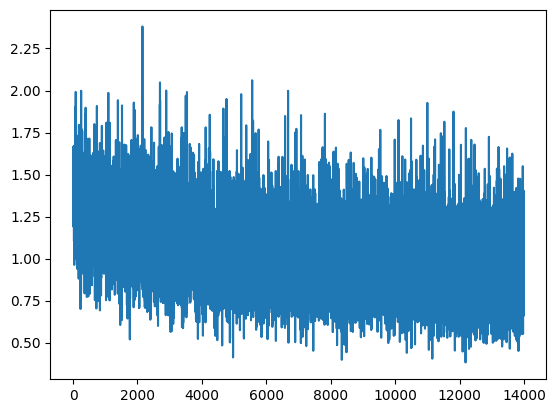

In [19]:
plt.plot(train_losses)

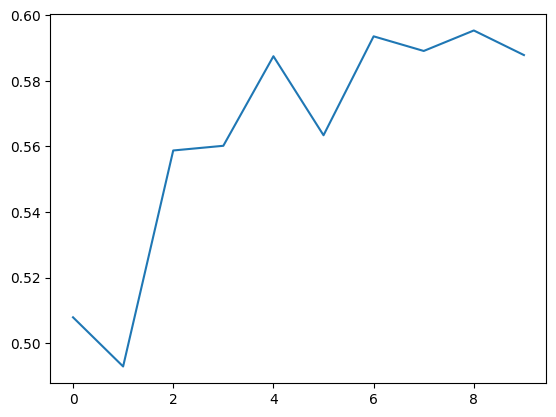

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [22]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3292/5600 (0.5879)
{'acc_detail': tensor([0.8629, 0.5186, 0.6771, 0.2929], device='cuda:0'),
 'acc_unweighted': tensor(0.5879, device='cuda:0'),
 'acc_weighted': tensor(0.5879, device='cuda:0'),
 'f1s': tensor(0.5701, device='cuda:0'),
 'f1s_detail': tensor([0.6691, 0.5723, 0.6702, 0.3689], device='cuda:0'),
 'precision_detail': tensor([0.5464, 0.6385, 0.6634, 0.4982], device='cuda:0'),
 'recall_detail': tensor([0.8629, 0.5186, 0.6771, 0.2929], device='cuda:0'),
 'rocauc': tensor([0.8954, 0.8564, 0.8813, 0.7650], device='cuda:0'),
 'uar': tensor(0.5879, device='cuda:0'),
 'wap': tensor(0.5866, device='cuda:0')}


tensor([[1208,   37,   31,  124],
        [ 154,  726,  330,  190],
        [ 161,  192,  948,   99],
        [ 688,  182,  120,  410]], device='cuda:0')

In [23]:
model_path = '../models_esd4/esd4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                         | 0.0005714285714285715/50 [00:00<8:00:52, 577.05s/it]

Train Epoch: 11 [0/22400 (0%)]	Loss: 1.087191
Mem before-during-after: 30240256 3508747776 36906496


  0%|                          | 0.023428571428571413/50 [00:15<9:45:52, 703.37s/it]

Train Epoch: 11 [640/22400 (3%)]	Loss: 1.023507
Mem before-during-after: 36906496 3515988480 36906496


  0%|                          | 0.046285714285714215/50 [00:30<9:25:43, 679.51s/it]

Train Epoch: 11 [1280/22400 (6%)]	Loss: 0.555500
Mem before-during-after: 37363200 3516003328 37233152


  0%|                           | 0.06914285714285702/50 [00:46<9:50:18, 709.36s/it]

Train Epoch: 11 [1920/22400 (9%)]	Loss: 0.921392
Mem before-during-after: 36906496 3188882432 36906496


  0%|                          | 0.09199999999999982/50 [01:01<10:30:30, 758.00s/it]

Train Epoch: 11 [2560/22400 (11%)]	Loss: 0.997889
Mem before-during-after: 37121024 3515692032 37401088


  0%|                          | 0.11485714285714262/50 [01:17<10:15:21, 740.12s/it]

Train Epoch: 11 [3200/22400 (14%)]	Loss: 0.951039
Mem before-during-after: 37624832 3515220480 37624832


  0%|                          | 0.13771428571428573/50 [01:33<10:23:23, 750.14s/it]

Train Epoch: 11 [3840/22400 (17%)]	Loss: 0.889724
Mem before-during-after: 37821952 3516325376 38596608


  0%|                            | 0.1605714285714291/50 [01:49<9:35:03, 692.29s/it]

Train Epoch: 11 [4480/22400 (20%)]	Loss: 0.926182
Mem before-during-after: 37103616 3514930688 36906496


  0%|                           | 0.18342857142857244/50 [02:04<9:38:58, 697.34s/it]

Train Epoch: 11 [5120/22400 (23%)]	Loss: 0.840410
Mem before-during-after: 37080576 3515846656 37213696


  0%|                           | 0.2062857142857158/50 [02:20<10:22:49, 750.48s/it]

Train Epoch: 11 [5760/22400 (26%)]	Loss: 1.229401
Mem before-during-after: 36915712 3515220480 36915712


  0%|                           | 0.22914285714285915/50 [02:35<9:33:39, 691.55s/it]

Train Epoch: 11 [6400/22400 (29%)]	Loss: 0.661059
Mem before-during-after: 37746176 3515955712 37309952


  1%|▏                           | 0.2520000000000024/50 [02:50<9:36:19, 695.09s/it]

Train Epoch: 11 [7040/22400 (31%)]	Loss: 0.621364
Mem before-during-after: 36906496 3514320384 36906496


  1%|▏                         | 0.27485714285714463/50 [03:06<10:16:35, 744.00s/it]

Train Epoch: 11 [7680/22400 (34%)]	Loss: 0.939661
Mem before-during-after: 36906496 3516325376 36906496


  1%|▏                           | 0.2977142857142869/50 [03:22<9:50:30, 712.86s/it]

Train Epoch: 11 [8320/22400 (37%)]	Loss: 0.894769
Mem before-during-after: 37299712 3514453504 37757952


  1%|▏                          | 0.3205714285714291/50 [03:37<10:12:50, 740.16s/it]

Train Epoch: 11 [8960/22400 (40%)]	Loss: 0.981379
Mem before-during-after: 37491712 3515203072 36906496


  1%|▏                          | 0.34342857142857136/50 [03:53<9:42:40, 704.05s/it]

Train Epoch: 11 [9600/22400 (43%)]	Loss: 1.008088
Mem before-during-after: 36906496 3514617856 37624832


  1%|▏                          | 0.3662857142857136/50 [04:08<10:14:17, 742.59s/it]

Train Epoch: 11 [10240/22400 (46%)]	Loss: 0.683484
Mem before-during-after: 37925888 3516325376 37925888


  1%|▏                         | 0.38914285714285585/50 [04:24<10:34:54, 767.87s/it]

Train Epoch: 11 [10880/22400 (49%)]	Loss: 0.896269
Mem before-during-after: 37821952 3516325376 38596608


  1%|▏                           | 0.4119999999999981/50 [04:40<9:56:03, 721.21s/it]

Train Epoch: 11 [11520/22400 (51%)]	Loss: 1.164937
Mem before-during-after: 36906496 3147074048 36906496


  1%|▏                          | 0.43485714285714033/50 [04:55<9:11:21, 667.43s/it]

Train Epoch: 11 [12160/22400 (54%)]	Loss: 1.223494
Mem before-during-after: 36906496 3514898944 36906496


  1%|▎                           | 0.4577142857142826/50 [05:10<9:59:39, 726.25s/it]

Train Epoch: 11 [12800/22400 (57%)]	Loss: 0.578523
Mem before-during-after: 36906496 3515080704 36906496


  1%|▎                          | 0.4805714285714248/50 [05:26<10:40:19, 775.84s/it]

Train Epoch: 11 [13440/22400 (60%)]	Loss: 0.725438
Mem before-during-after: 38024704 3515620352 37039616


  1%|▎                           | 0.5034285714285671/50 [05:41<9:45:14, 709.42s/it]

Train Epoch: 11 [14080/22400 (63%)]	Loss: 1.080338
Mem before-during-after: 37204480 3327225344 37305856


  1%|▎                          | 0.5262857142857094/50 [05:56<10:14:20, 745.05s/it]

Train Epoch: 11 [14720/22400 (66%)]	Loss: 1.509306
Mem before-during-after: 36906496 3515063296 36906496


  1%|▎                           | 0.5491428571428516/50 [06:12<9:45:58, 710.97s/it]

Train Epoch: 11 [15360/22400 (69%)]	Loss: 1.039364
Mem before-during-after: 37895168 3057550848 36986880


  1%|▎                           | 0.5719999999999938/50 [06:28<9:28:39, 690.28s/it]

Train Epoch: 11 [16000/22400 (71%)]	Loss: 0.750449
Mem before-during-after: 36906496 3515424768 37821952


  1%|▎                           | 0.5948571428571361/50 [06:43<9:24:21, 685.39s/it]

Train Epoch: 11 [16640/22400 (74%)]	Loss: 1.049498
Mem before-during-after: 37540352 3515872256 36954112


  1%|▎                          | 0.6177142857142783/50 [07:00<10:52:48, 793.17s/it]

Train Epoch: 11 [17280/22400 (77%)]	Loss: 0.964703
Mem before-during-after: 36935168 3501335552 36906496


  1%|▎                          | 0.6405714285714206/50 [07:15<10:11:41, 743.56s/it]

Train Epoch: 11 [17920/22400 (80%)]	Loss: 0.663625
Mem before-during-after: 37624832 3515220480 37624832


  1%|▎                           | 0.6634285714285628/50 [07:31<9:42:27, 708.35s/it]

Train Epoch: 11 [18560/22400 (83%)]	Loss: 1.131571
Mem before-during-after: 37039616 2997640192 36906496


  1%|▎                          | 0.6862857142857051/50 [07:47<10:14:26, 747.58s/it]

Train Epoch: 11 [19200/22400 (86%)]	Loss: 1.034515
Mem before-during-after: 37624832 3466027520 36906496


  1%|▍                           | 0.7091428571428473/50 [08:02<9:55:25, 724.80s/it]

Train Epoch: 11 [19840/22400 (89%)]	Loss: 0.860338
Mem before-during-after: 36906496 3516069376 36906496


  1%|▍                           | 0.7319999999999895/50 [08:17<9:04:42, 663.37s/it]

Train Epoch: 11 [20480/22400 (91%)]	Loss: 0.839733
Mem before-during-after: 37190656 3182554112 37190656


  2%|▍                          | 0.7548571428571318/50 [08:33<10:35:04, 773.78s/it]

Train Epoch: 11 [21120/22400 (94%)]	Loss: 0.909948
Mem before-during-after: 36915712 3514644480 36915712


  2%|▍                           | 0.777714285714274/50 [08:49<10:43:49, 784.80s/it]

Train Epoch: 11 [21760/22400 (97%)]	Loss: 0.706648
Mem before-during-after: 37690368 3515419136 37690368


  2%|▌                           | 0.9999999999999823/50 [10:15<5:03:19, 371.43s/it]


Test Epoch: 11	Accuracy: 3482/5600 (62%)

saved model: ../models_esd4/esd4_m18_best_11epoch.pt


  2%|▌                            | 1.000571428571411/50 [10:15<5:57:08, 437.32s/it]

Train Epoch: 12 [0/22400 (0%)]	Loss: 1.040154
Mem before-during-after: 37929472 3515844096 37933568


  2%|▌                          | 1.0234285714285576/50 [10:31<10:00:55, 736.17s/it]

Train Epoch: 12 [640/22400 (3%)]	Loss: 0.602516
Mem before-during-after: 37762048 3516069376 37895168


  2%|▌                           | 1.0462857142857043/50 [10:47<9:56:17, 730.84s/it]

Train Epoch: 12 [1280/22400 (6%)]	Loss: 1.161236
Mem before-during-after: 37933568 3517015552 38841344


  2%|▌                            | 1.069142857142851/50 [11:02<9:22:29, 689.75s/it]

Train Epoch: 12 [1920/22400 (9%)]	Loss: 0.988874
Mem before-during-after: 37944832 3517309952 37933568


  2%|▌                          | 1.0919999999999976/50 [11:17<10:08:41, 746.73s/it]

Train Epoch: 12 [2560/22400 (11%)]	Loss: 0.909395
Mem before-during-after: 36906496 3516325376 36906496


  2%|▌                          | 1.1148571428571443/50 [11:33<10:04:05, 741.43s/it]

Train Epoch: 12 [3200/22400 (14%)]	Loss: 0.734880
Mem before-during-after: 38841344 3516882432 38708224


  2%|▋                           | 1.137714285714291/50 [11:48<10:39:41, 785.51s/it]

Train Epoch: 12 [3840/22400 (17%)]	Loss: 0.963478
Mem before-during-after: 37331456 3516345856 37681152


  2%|▋                          | 1.1605714285714377/50 [12:04<10:13:12, 753.34s/it]

Train Epoch: 12 [4480/22400 (20%)]	Loss: 0.582603
Mem before-during-after: 37895168 3516261376 37895168


  2%|▋                           | 1.1834285714285844/50 [12:19<9:55:19, 731.71s/it]

Train Epoch: 12 [5120/22400 (23%)]	Loss: 1.168646
Mem before-during-after: 37933568 3515992064 37933568


  2%|▋                            | 1.206285714285731/50 [12:34<9:30:42, 701.78s/it]

Train Epoch: 12 [5760/22400 (26%)]	Loss: 0.742152
Mem before-during-after: 36906496 3515651584 36906496


  2%|▋                          | 1.2291428571428777/50 [12:50<10:00:21, 738.59s/it]

Train Epoch: 12 [6400/22400 (29%)]	Loss: 0.875261
Mem before-during-after: 37895168 3473245184 36906496


  3%|▋                          | 1.2520000000000244/50 [13:05<10:30:28, 776.01s/it]

Train Epoch: 12 [7040/22400 (31%)]	Loss: 0.920303
Mem before-during-after: 36906496 3516325376 37317632


  3%|▋                            | 1.274857142857171/50 [13:21<9:58:11, 736.61s/it]

Train Epoch: 12 [7680/22400 (34%)]	Loss: 0.909905
Mem before-during-after: 37491712 3515203072 36906496


  3%|▋                           | 1.2977142857143178/50 [13:37<9:55:43, 733.92s/it]

Train Epoch: 12 [8320/22400 (37%)]	Loss: 1.037901
Mem before-during-after: 37025280 3218288640 36906496


  3%|▋                          | 1.3205714285714645/50 [13:53<10:05:13, 745.98s/it]

Train Epoch: 12 [8960/22400 (40%)]	Loss: 0.732747
Mem before-during-after: 37895168 3516261376 37895168


  3%|▊                           | 1.3434285714286112/50 [14:08<9:39:04, 714.07s/it]

Train Epoch: 12 [9600/22400 (43%)]	Loss: 0.808621
Mem before-during-after: 37316608 3515585536 36906496


  3%|▋                          | 1.3662857142857578/50 [14:23<10:13:56, 757.43s/it]

Train Epoch: 12 [10240/22400 (46%)]	Loss: 0.994974
Mem before-during-after: 37895168 3516261376 37895168


  3%|▊                           | 1.3891428571429045/50 [14:39<9:52:17, 731.07s/it]

Train Epoch: 12 [10880/22400 (49%)]	Loss: 0.752971
Mem before-during-after: 37933568 3517145600 37933568


  3%|▊                           | 1.4120000000000512/50 [14:54<9:52:34, 731.76s/it]

Train Epoch: 12 [11520/22400 (51%)]	Loss: 1.207020
Mem before-during-after: 37213696 3516028416 37245440


  3%|▊                           | 1.434857142857198/50 [15:10<10:02:23, 744.23s/it]

Train Epoch: 12 [12160/22400 (54%)]	Loss: 1.170444
Mem before-during-after: 36906496 3516325376 36906496


  3%|▊                          | 1.4577142857143446/50 [15:26<10:05:23, 748.29s/it]

Train Epoch: 12 [12800/22400 (57%)]	Loss: 0.726676
Mem before-during-after: 37891072 3516527616 36906496


  3%|▊                          | 1.4805714285714913/50 [15:41<10:01:16, 743.55s/it]

Train Epoch: 12 [13440/22400 (60%)]	Loss: 0.982869
Mem before-during-after: 37531136 3516315136 37531136


  3%|▊                           | 1.503428571428638/50 [15:56<10:01:10, 743.78s/it]

Train Epoch: 12 [14080/22400 (63%)]	Loss: 1.054729
Mem before-during-after: 36906496 3514831872 37491712


  3%|▊                           | 1.5262857142857846/50 [16:12<9:57:37, 739.72s/it]

Train Epoch: 12 [14720/22400 (66%)]	Loss: 0.826775
Mem before-during-after: 37120512 3514831872 37120512


  3%|▊                           | 1.5491428571429313/50 [16:27<9:58:09, 740.74s/it]

Train Epoch: 12 [15360/22400 (69%)]	Loss: 0.914674
Mem before-during-after: 37895168 3516261376 37895168


  3%|▉                           | 1.572000000000078/50 [16:43<10:16:55, 764.35s/it]

Train Epoch: 12 [16000/22400 (71%)]	Loss: 0.853417
Mem before-during-after: 37681152 3516325376 37681152


  3%|▊                          | 1.5948571428572247/50 [16:59<10:16:25, 764.08s/it]

Train Epoch: 12 [16640/22400 (74%)]	Loss: 0.566656
Mem before-during-after: 37947392 3514502144 36906496


  3%|▊                          | 1.6177142857143714/50 [17:14<10:03:34, 748.50s/it]

Train Epoch: 12 [17280/22400 (77%)]	Loss: 0.643666
Mem before-during-after: 36906496 3515567616 36906496


  3%|▉                           | 1.640571428571518/50 [17:30<10:39:21, 793.27s/it]

Train Epoch: 12 [17920/22400 (80%)]	Loss: 0.816834
Mem before-during-after: 37895168 3516261376 37895168


  3%|▉                           | 1.6634285714286647/50 [17:45<8:58:10, 668.04s/it]

Train Epoch: 12 [18560/22400 (83%)]	Loss: 1.001615
Mem before-during-after: 37548544 2997258240 36906496


  3%|▉                           | 1.6862857142858114/50 [18:00<9:57:09, 741.59s/it]

Train Epoch: 12 [19200/22400 (86%)]	Loss: 0.768711
Mem before-during-after: 36906496 3515848192 36906496


  3%|▉                           | 1.709142857142958/50 [18:16<10:34:05, 787.84s/it]

Train Epoch: 12 [19840/22400 (89%)]	Loss: 0.611993
Mem before-during-after: 36906496 3515139584 36906496


  3%|▉                           | 1.7320000000001048/50 [18:31<9:51:47, 735.64s/it]

Train Epoch: 12 [20480/22400 (91%)]	Loss: 0.810429
Mem before-during-after: 36906496 3515451904 36906496


  4%|▉                           | 1.7548571428572515/50 [18:47<9:57:00, 742.46s/it]

Train Epoch: 12 [21120/22400 (94%)]	Loss: 0.880150
Mem before-during-after: 36906496 3515139584 36906496


  4%|▉                          | 1.7777142857143982/50 [19:02<10:10:50, 760.04s/it]

Train Epoch: 12 [21760/22400 (97%)]	Loss: 0.850828
Mem before-during-after: 37548544 3516429824 38312448


  4%|█                           | 2.0000000000001497/50 [20:28<4:48:24, 360.52s/it]


Test Epoch: 12	Accuracy: 3497/5600 (62%)

saved model: ../models_esd4/esd4_m18_best_12epoch.pt


  4%|█▏                           | 2.000571428571578/50 [20:28<5:41:59, 427.50s/it]

Train Epoch: 13 [0/22400 (0%)]	Loss: 0.702425
Mem before-during-after: 37921792 3516325376 38092288


  4%|█▏                           | 2.023428571428716/50 [20:44<9:28:34, 711.06s/it]

Train Epoch: 13 [640/22400 (3%)]	Loss: 0.778342
Mem before-during-after: 36906496 3514933248 36906496


  4%|█▏                          | 2.0462857142858537/50 [20:59<9:00:40, 676.50s/it]

Train Epoch: 13 [1280/22400 (6%)]	Loss: 0.746287
Mem before-during-after: 37876224 3514320384 36925440


  4%|█                          | 2.0691428571429915/50 [21:15<10:04:31, 756.74s/it]

Train Epoch: 13 [1920/22400 (9%)]	Loss: 0.717479
Mem before-during-after: 36988416 3514802176 36906496


  4%|█▏                          | 2.0920000000001293/50 [21:31<9:49:41, 738.52s/it]

Train Epoch: 13 [2560/22400 (11%)]	Loss: 0.992796
Mem before-during-after: 37933568 3517015552 38841344


  4%|█▏                           | 2.114857142857267/50 [21:46<9:26:54, 710.33s/it]

Train Epoch: 13 [3200/22400 (14%)]	Loss: 0.871138
Mem before-during-after: 37681152 3514617856 37624832


  4%|█▏                           | 2.137714285714405/50 [22:02<9:51:24, 741.39s/it]

Train Epoch: 13 [3840/22400 (17%)]	Loss: 0.901697
Mem before-during-after: 36906496 3514705920 37110272


  4%|█▏                          | 2.1605714285715427/50 [22:17<9:31:50, 717.19s/it]

Train Epoch: 13 [4480/22400 (20%)]	Loss: 0.609148
Mem before-during-after: 36950528 3515540480 36906496


  4%|█▏                          | 2.1834285714286805/50 [22:33<9:30:39, 716.06s/it]

Train Epoch: 13 [5120/22400 (23%)]	Loss: 0.949124
Mem before-during-after: 37027328 3514886144 36906496


  4%|█▏                          | 2.2062857142858183/50 [22:50<9:23:24, 707.29s/it]

Train Epoch: 13 [5760/22400 (26%)]	Loss: 1.011040
Mem before-during-after: 37681152 2900655616 36906496


  4%|█▎                           | 2.229142857142956/50 [23:06<9:47:57, 738.48s/it]

Train Epoch: 13 [6400/22400 (29%)]	Loss: 0.911137
Mem before-during-after: 38596608 3516325376 38596608


  5%|█▎                           | 2.252000000000094/50 [23:21<9:26:23, 711.73s/it]

Train Epoch: 13 [7040/22400 (31%)]	Loss: 0.492413
Mem before-during-after: 36906496 3514866688 37169152


  5%|█▎                          | 2.2748571428572317/50 [23:37<9:56:07, 749.45s/it]

Train Epoch: 13 [7680/22400 (34%)]	Loss: 0.615481
Mem before-during-after: 36906496 3514831872 37491712


  5%|█▎                          | 2.2977142857143695/50 [23:52<9:47:04, 738.43s/it]

Train Epoch: 13 [8320/22400 (37%)]	Loss: 1.276929
Mem before-during-after: 37826048 3516297216 37826048


  5%|█▎                          | 2.3205714285715073/50 [24:07<9:55:18, 749.15s/it]

Train Epoch: 13 [8960/22400 (40%)]	Loss: 0.995432
Mem before-during-after: 37302272 3515220480 37302272


  5%|█▎                           | 2.343428571428645/50 [24:22<9:20:51, 706.13s/it]

Train Epoch: 13 [9600/22400 (43%)]	Loss: 0.749178
Mem before-during-after: 37933568 3517015552 38841344


  5%|█▎                          | 2.366285714285783/50 [24:38<10:23:23, 785.23s/it]

Train Epoch: 13 [10240/22400 (46%)]	Loss: 0.608093
Mem before-during-after: 37681152 3515409920 37681152


  5%|█▎                          | 2.3891428571429207/50 [24:53<9:42:00, 733.46s/it]

Train Epoch: 13 [10880/22400 (49%)]	Loss: 1.358494
Mem before-during-after: 36906496 3514502144 36906496


  5%|█▎                          | 2.4120000000000585/50 [25:09<9:28:21, 716.59s/it]

Train Epoch: 13 [11520/22400 (51%)]	Loss: 1.182054
Mem before-during-after: 37814272 3516233216 37681152


  5%|█▎                         | 2.4348571428571963/50 [25:24<10:31:26, 796.52s/it]

Train Epoch: 13 [12160/22400 (54%)]	Loss: 0.715762
Mem before-during-after: 36906496 3516325376 36906496


  5%|█▍                           | 2.457714285714334/50 [25:40<9:23:32, 711.20s/it]

Train Epoch: 13 [12800/22400 (57%)]	Loss: 0.800917
Mem before-during-after: 38596608 3164072448 37821952


  5%|█▍                          | 2.480571428571472/50 [25:56<10:42:47, 811.61s/it]

Train Epoch: 13 [13440/22400 (60%)]	Loss: 0.691867
Mem before-during-after: 37039616 3515139584 36906496


  5%|█▎                         | 2.5034285714286098/50 [26:11<10:02:20, 760.91s/it]

Train Epoch: 13 [14080/22400 (63%)]	Loss: 0.574218
Mem before-during-after: 38092288 3516261376 37895168


  5%|█▍                          | 2.5262857142857476/50 [26:26<9:48:37, 743.94s/it]

Train Epoch: 13 [14720/22400 (66%)]	Loss: 1.085266
Mem before-during-after: 37814272 3515855360 37681152


  5%|█▍                          | 2.5491428571428854/50 [26:42<9:31:47, 723.01s/it]

Train Epoch: 13 [15360/22400 (69%)]	Loss: 0.837303
Mem before-during-after: 37895168 3416978944 36906496


  5%|█▍                           | 2.572000000000023/50 [26:57<9:05:23, 689.95s/it]

Train Epoch: 13 [16000/22400 (71%)]	Loss: 0.787540
Mem before-during-after: 37312000 3516011520 36906496


  5%|█▌                           | 2.594857142857161/50 [27:12<9:10:19, 696.54s/it]

Train Epoch: 13 [16640/22400 (74%)]	Loss: 0.460622
Mem before-during-after: 36906496 3514436096 36906496


  5%|█▍                         | 2.6177142857142988/50 [27:28<10:19:32, 784.52s/it]

Train Epoch: 13 [17280/22400 (77%)]	Loss: 0.755630
Mem before-during-after: 37681152 3514617856 37624832


  5%|█▍                          | 2.6405714285714366/50 [27:44<9:43:35, 739.36s/it]

Train Epoch: 13 [17920/22400 (80%)]	Loss: 1.050005
Mem before-during-after: 38596608 3516325376 38596608


  5%|█▍                         | 2.6634285714285744/50 [27:59<10:12:12, 775.99s/it]

Train Epoch: 13 [18560/22400 (83%)]	Loss: 0.839254
Mem before-during-after: 36906496 3515623936 37895168


  5%|█▌                           | 2.686285714285712/50 [28:15<9:46:55, 744.31s/it]

Train Epoch: 13 [19200/22400 (86%)]	Loss: 1.378770
Mem before-during-after: 38596608 3516325376 38596608


  5%|█▋                            | 2.70914285714285/50 [28:31<9:56:27, 756.74s/it]

Train Epoch: 13 [19840/22400 (89%)]	Loss: 0.899470
Mem before-during-after: 36906496 3515139584 36906496


  5%|█▌                          | 2.7319999999999878/50 [28:46<9:42:02, 738.82s/it]

Train Epoch: 13 [20480/22400 (91%)]	Loss: 1.109148
Mem before-during-after: 36932096 3515353600 36932096


  6%|█▌                          | 2.7548571428571256/50 [29:02<9:00:24, 686.30s/it]

Train Epoch: 13 [21120/22400 (94%)]	Loss: 0.768001
Mem before-during-after: 37365248 3515915264 36906496


  6%|█▌                          | 2.7777142857142634/50 [29:18<9:46:23, 745.07s/it]

Train Epoch: 13 [21760/22400 (97%)]	Loss: 0.922819
Mem before-during-after: 37361664 3514650624 37236736


  6%|█▋                          | 2.9999999999999285/50 [30:44<4:43:39, 362.12s/it]


Test Epoch: 13	Accuracy: 3486/5600 (62%)



  6%|█▋                           | 3.000571428571357/50 [30:44<5:43:42, 438.79s/it]

Train Epoch: 14 [0/22400 (0%)]	Loss: 0.580883
Mem before-during-after: 36902400 3515139584 36906496


  6%|█▋                          | 3.0234285714284947/50 [31:00<9:42:29, 743.99s/it]

Train Epoch: 14 [640/22400 (3%)]	Loss: 1.040531
Mem before-during-after: 37895168 3516261376 37895168


  6%|█▋                          | 3.0462857142856326/50 [31:15<8:59:54, 689.93s/it]

Train Epoch: 14 [1280/22400 (6%)]	Loss: 0.819728
Mem before-during-after: 37714944 3377369600 36940288


  6%|█▋                          | 3.0691428571427704/50 [31:30<9:00:11, 690.62s/it]

Train Epoch: 14 [1920/22400 (9%)]	Loss: 0.923248
Mem before-during-after: 36906496 3515655168 36906496


  6%|█▊                           | 3.091999999999908/50 [31:46<9:46:58, 750.80s/it]

Train Epoch: 14 [2560/22400 (11%)]	Loss: 0.829219
Mem before-during-after: 36906496 3515455488 37491712


  6%|█▊                           | 3.114857142857046/50 [32:02<9:29:54, 729.31s/it]

Train Epoch: 14 [3200/22400 (14%)]	Loss: 0.742258
Mem before-during-after: 36906496 3515567616 36906496


  6%|█▊                          | 3.1377142857141838/50 [32:17<9:34:15, 735.24s/it]

Train Epoch: 14 [3840/22400 (17%)]	Loss: 0.925010
Mem before-during-after: 37540352 3516043776 37821952


  6%|█▊                          | 3.1605714285713216/50 [32:32<9:20:25, 717.89s/it]

Train Epoch: 14 [4480/22400 (20%)]	Loss: 0.699230
Mem before-during-after: 37285376 3516134912 37253632


  6%|█▊                          | 3.1834285714284594/50 [32:48<9:41:06, 744.74s/it]

Train Epoch: 14 [5120/22400 (23%)]	Loss: 0.976012
Mem before-during-after: 37285376 3515329536 37253632


  6%|█▊                           | 3.206285714285597/50 [33:04<9:46:32, 752.08s/it]

Train Epoch: 14 [5760/22400 (26%)]	Loss: 1.072076
Mem before-during-after: 37895168 3516269568 37895168


  6%|█▊                           | 3.229142857142735/50 [33:19<9:24:47, 724.53s/it]

Train Epoch: 14 [6400/22400 (29%)]	Loss: 0.980456
Mem before-during-after: 37071360 3515691008 36906496


  7%|█▊                          | 3.2519999999998728/50 [33:35<8:50:17, 680.62s/it]

Train Epoch: 14 [7040/22400 (31%)]	Loss: 1.346033
Mem before-during-after: 36906496 3516149760 36906496


  7%|█▊                          | 3.2748571428570106/50 [33:50<9:41:28, 746.68s/it]

Train Epoch: 14 [7680/22400 (34%)]	Loss: 0.780124
Mem before-during-after: 36906496 3515451904 36906496


  7%|█▊                          | 3.2977142857141484/50 [34:05<9:43:00, 749.01s/it]

Train Epoch: 14 [8320/22400 (37%)]	Loss: 1.031602
Mem before-during-after: 38596608 3417888256 37084672


  7%|█▉                           | 3.320571428571286/50 [34:21<9:50:29, 758.99s/it]

Train Epoch: 14 [8960/22400 (40%)]	Loss: 0.811675
Mem before-during-after: 37878272 3516261376 37895168


  7%|█▉                           | 3.343428571428424/50 [34:37<9:47:15, 755.21s/it]

Train Epoch: 14 [9600/22400 (43%)]	Loss: 0.703870
Mem before-during-after: 37421568 3473233408 36906496


  7%|█▉                           | 3.366285714285562/50 [34:53<9:56:52, 767.94s/it]

Train Epoch: 14 [10240/22400 (46%)]	Loss: 1.235110
Mem before-during-after: 37895168 3516261376 37895168


  7%|█▉                          | 3.3891428571426996/50 [35:08<9:29:32, 733.13s/it]

Train Epoch: 14 [10880/22400 (49%)]	Loss: 0.962174
Mem before-during-after: 37933568 3517015552 37933568


  7%|█▉                          | 3.4119999999998374/50 [35:24<9:51:19, 761.57s/it]

Train Epoch: 14 [11520/22400 (51%)]	Loss: 0.724665
Mem before-during-after: 37792768 3516325376 37018112


  7%|█▉                           | 3.434857142856975/50 [35:39<9:15:27, 715.72s/it]

Train Epoch: 14 [12160/22400 (54%)]	Loss: 1.224183
Mem before-during-after: 38596608 3417951744 37084672


  7%|██                           | 3.457714285714113/50 [35:55<9:34:36, 740.75s/it]

Train Epoch: 14 [12800/22400 (57%)]	Loss: 0.835509
Mem before-during-after: 37933568 3517015552 38841344


  7%|██                           | 3.480571428571251/50 [36:11<9:37:28, 744.81s/it]

Train Epoch: 14 [13440/22400 (60%)]	Loss: 0.552479
Mem before-during-after: 37895168 3516261376 37895168


  7%|█▉                          | 3.5034285714283886/50 [36:26<9:15:28, 716.79s/it]

Train Epoch: 14 [14080/22400 (63%)]	Loss: 0.877701
Mem before-during-after: 36906496 3514933760 36906496


  7%|█▉                         | 3.5262857142855264/50 [36:42<10:16:05, 795.41s/it]

Train Epoch: 14 [14720/22400 (66%)]	Loss: 0.787186
Mem before-during-after: 37018112 3516325376 37792768


  7%|██                           | 3.549142857142664/50 [36:57<9:07:21, 707.01s/it]

Train Epoch: 14 [15360/22400 (69%)]	Loss: 0.881028
Mem before-during-after: 36906496 3291968512 37160448


  7%|██                           | 3.571999999999802/50 [37:13<9:39:16, 748.60s/it]

Train Epoch: 14 [16000/22400 (71%)]	Loss: 0.653028
Mem before-during-after: 36906496 3514750976 36906496


  7%|██▏                           | 3.59485714285694/50 [37:29<9:57:43, 772.84s/it]

Train Epoch: 14 [16640/22400 (74%)]	Loss: 1.005292
Mem before-during-after: 36906496 3514635264 36906496


  7%|██                          | 3.6177142857140776/50 [37:44<9:05:34, 705.75s/it]

Train Epoch: 14 [17280/22400 (77%)]	Loss: 0.713600
Mem before-during-after: 36906496 3018078208 36906496


  7%|██                          | 3.6405714285712154/50 [38:00<9:34:59, 744.17s/it]

Train Epoch: 14 [17920/22400 (80%)]	Loss: 0.679203
Mem before-during-after: 37895168 3516261376 37895168


  7%|██                           | 3.663428571428353/50 [38:15<9:01:50, 701.61s/it]

Train Epoch: 14 [18560/22400 (83%)]	Loss: 0.840868
Mem before-during-after: 37925888 3362778624 37108736


  7%|██▏                          | 3.686285714285491/50 [38:30<9:27:01, 734.60s/it]

Train Epoch: 14 [19200/22400 (86%)]	Loss: 0.811273
Mem before-during-after: 36906496 3515353600 36906496


  7%|██▏                          | 3.709142857142629/50 [38:46<9:28:35, 736.98s/it]

Train Epoch: 14 [19840/22400 (89%)]	Loss: 0.661945
Mem before-during-after: 37895168 3515623936 37895168


  7%|██                          | 3.7319999999997666/50 [39:01<9:20:43, 727.13s/it]

Train Epoch: 14 [20480/22400 (91%)]	Loss: 0.850399
Mem before-during-after: 37955072 3430215680 37978624


  8%|██                         | 3.7548571428569044/50 [39:17<10:12:53, 795.18s/it]

Train Epoch: 14 [21120/22400 (94%)]	Loss: 0.683683
Mem before-during-after: 37018112 3516325376 38030848


  8%|██▏                          | 3.777714285714042/50 [39:33<8:26:08, 657.01s/it]

Train Epoch: 14 [21760/22400 (97%)]	Loss: 0.654153
Mem before-during-after: 36906496 3516093440 36946432


  8%|██▏                         | 3.9999999999997073/50 [41:00<4:36:41, 360.91s/it]


Test Epoch: 14	Accuracy: 3530/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_14epoch.pt


  8%|██▎                          | 4.000571428571136/50 [41:00<5:27:54, 427.71s/it]

Train Epoch: 15 [0/22400 (0%)]	Loss: 0.754956
Mem before-during-after: 36902400 3515139584 36906496


  8%|██▎                          | 4.023428571428291/50 [41:16<9:38:58, 755.58s/it]

Train Epoch: 15 [640/22400 (3%)]	Loss: 0.632962
Mem before-during-after: 37317632 3516261376 37895168


  8%|██▎                          | 4.046285714285447/50 [41:32<9:53:42, 775.19s/it]

Train Epoch: 15 [1280/22400 (6%)]	Loss: 0.497452
Mem before-during-after: 37120512 3515139584 36906496


  8%|██▎                         | 4.0691428571426025/50 [41:47<8:48:02, 689.78s/it]

Train Epoch: 15 [1920/22400 (9%)]	Loss: 0.695947
Mem before-during-after: 38095360 3397011968 37261824


  8%|██▎                          | 4.091999999999758/50 [42:03<9:23:50, 736.93s/it]

Train Epoch: 15 [2560/22400 (11%)]	Loss: 0.923955
Mem before-during-after: 37895168 3516261376 37895168


  8%|██▍                          | 4.114857142856914/50 [42:18<8:56:50, 701.97s/it]

Train Epoch: 15 [3200/22400 (14%)]	Loss: 0.612696
Mem before-during-after: 37062144 3515615232 37681152


  8%|██▍                          | 4.137714285714069/50 [42:34<9:26:45, 741.47s/it]

Train Epoch: 15 [3840/22400 (17%)]	Loss: 1.097839
Mem before-during-after: 37895168 3516261376 37895168


  8%|██▍                          | 4.160571428571225/50 [42:49<9:08:34, 718.05s/it]

Train Epoch: 15 [4480/22400 (20%)]	Loss: 0.802396
Mem before-during-after: 36906496 3514849280 36906496


  8%|██▌                           | 4.18342857142838/50 [43:04<9:24:46, 739.62s/it]

Train Epoch: 15 [5120/22400 (23%)]	Loss: 0.723453
Mem before-during-after: 37624832 3515844096 37624832


  8%|██▍                          | 4.206285714285536/50 [43:20<9:11:37, 722.75s/it]

Train Epoch: 15 [5760/22400 (26%)]	Loss: 1.068328
Mem before-during-after: 37895168 3266831872 36906496


  8%|██▎                         | 4.2291428571426914/50 [43:36<9:37:50, 757.48s/it]

Train Epoch: 15 [6400/22400 (29%)]	Loss: 1.016101
Mem before-during-after: 37421568 3515844096 37421568


  9%|██▍                          | 4.251999999999847/50 [43:51<9:27:47, 744.68s/it]

Train Epoch: 15 [7040/22400 (31%)]	Loss: 1.205003
Mem before-during-after: 37204480 3515213824 37039616


  9%|██▍                          | 4.274857142857003/50 [44:06<8:42:13, 685.26s/it]

Train Epoch: 15 [7680/22400 (34%)]	Loss: 0.981993
Mem before-during-after: 37115392 3514760704 36906496


  9%|██▍                         | 4.297714285714158/50 [44:23<10:13:24, 805.30s/it]

Train Epoch: 15 [8320/22400 (37%)]	Loss: 0.614182
Mem before-during-after: 37698560 3516325376 37698560


  9%|██▌                          | 4.320571428571314/50 [44:39<9:33:55, 753.85s/it]

Train Epoch: 15 [8960/22400 (40%)]	Loss: 0.537035
Mem before-during-after: 37681152 3515409920 37681152


  9%|██▌                          | 4.343428571428469/50 [44:54<9:57:44, 785.54s/it]

Train Epoch: 15 [9600/22400 (43%)]	Loss: 0.814419
Mem before-during-after: 36906496 3515139584 36906496


  9%|██▌                          | 4.366285714285625/50 [45:10<9:39:39, 762.15s/it]

Train Epoch: 15 [10240/22400 (46%)]	Loss: 1.109258
Mem before-during-after: 38596608 3335173120 36944384


  9%|██▋                           | 4.38914285714278/50 [45:25<9:24:10, 742.16s/it]

Train Epoch: 15 [10880/22400 (49%)]	Loss: 0.839595
Mem before-during-after: 38708224 3517015552 37233152


  9%|██▌                          | 4.411999999999936/50 [45:41<9:38:26, 761.31s/it]

Train Epoch: 15 [11520/22400 (51%)]	Loss: 1.062423
Mem before-during-after: 37039616 3516325376 36906496


  9%|██▍                         | 4.4348571428570915/50 [45:57<9:30:10, 750.81s/it]

Train Epoch: 15 [12160/22400 (54%)]	Loss: 0.913690
Mem before-during-after: 36906496 3514502144 36906496


  9%|██▌                          | 4.457714285714247/50 [46:12<9:49:46, 777.01s/it]

Train Epoch: 15 [12800/22400 (57%)]	Loss: 0.562744
Mem before-during-after: 36906496 3516325376 36906496


  9%|██▌                          | 4.480571428571403/50 [46:28<9:37:39, 761.42s/it]

Train Epoch: 15 [13440/22400 (60%)]	Loss: 1.253242
Mem before-during-after: 36906496 3516063232 38532608


  9%|██▌                          | 4.503428571428558/50 [46:43<8:39:55, 685.67s/it]

Train Epoch: 15 [14080/22400 (63%)]	Loss: 0.727313
Mem before-during-after: 37681152 3376880128 38493696


  9%|██▋                          | 4.526285714285714/50 [46:59<9:33:57, 757.31s/it]

Train Epoch: 15 [14720/22400 (66%)]	Loss: 0.813056
Mem before-during-after: 36906496 3515139584 36906496


  9%|██▋                          | 4.549142857142869/50 [47:14<9:11:58, 728.67s/it]

Train Epoch: 15 [15360/22400 (69%)]	Loss: 1.295400
Mem before-during-after: 37821952 3301052416 37656064


  9%|██▋                          | 4.572000000000025/50 [47:30<9:26:59, 748.86s/it]

Train Epoch: 15 [16000/22400 (71%)]	Loss: 0.585082
Mem before-during-after: 37895168 3516261376 37895168


  9%|██▌                         | 4.5948571428571805/50 [47:46<9:51:30, 781.65s/it]

Train Epoch: 15 [16640/22400 (74%)]	Loss: 0.762699
Mem before-during-after: 38596608 3516325376 38596608


  9%|██▋                          | 4.617714285714336/50 [48:01<9:31:29, 755.57s/it]

Train Epoch: 15 [17280/22400 (77%)]	Loss: 0.909539
Mem before-during-after: 37039616 3515550720 36906496


  9%|██▋                          | 4.640571428571492/50 [48:16<9:23:06, 744.87s/it]

Train Epoch: 15 [17920/22400 (80%)]	Loss: 0.849381
Mem before-during-after: 37933568 3517015552 38841344


  9%|██▋                          | 4.663428571428647/50 [48:32<9:10:04, 727.99s/it]

Train Epoch: 15 [18560/22400 (83%)]	Loss: 0.604356
Mem before-during-after: 37018112 3514960896 37018112


  9%|██▋                          | 4.686285714285803/50 [48:47<9:11:25, 730.15s/it]

Train Epoch: 15 [19200/22400 (86%)]	Loss: 0.826795
Mem before-during-after: 36906496 3515691008 37071360


  9%|██▋                          | 4.709142857142958/50 [49:03<9:33:21, 759.57s/it]

Train Epoch: 15 [19840/22400 (89%)]	Loss: 0.766343
Mem before-during-after: 38596608 3516325376 38596608


  9%|██▋                          | 4.732000000000114/50 [49:18<9:40:41, 769.68s/it]

Train Epoch: 15 [20480/22400 (91%)]	Loss: 0.707005
Mem before-during-after: 37069312 3515705856 37814272


 10%|██▋                         | 4.7548571428572695/50 [49:34<8:36:23, 684.78s/it]

Train Epoch: 15 [21120/22400 (94%)]	Loss: 1.235772
Mem before-during-after: 38538752 3515621888 38092288


 10%|██▊                          | 4.777714285714425/50 [49:49<9:43:07, 773.68s/it]

Train Epoch: 15 [21760/22400 (97%)]	Loss: 1.037121
Mem before-during-after: 36906496 3514502144 36906496


 10%|██▉                          | 5.000000000000263/50 [51:16<4:23:00, 350.68s/it]


Test Epoch: 15	Accuracy: 3537/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_15epoch.pt


 10%|██▉                          | 5.000571428571692/50 [51:16<5:16:13, 421.64s/it]

Train Epoch: 16 [0/22400 (0%)]	Loss: 0.752575
Mem before-during-after: 36907008 3515028480 36911104


 10%|██▉                          | 5.023428571428847/50 [51:32<9:27:19, 756.82s/it]

Train Epoch: 16 [640/22400 (3%)]	Loss: 0.984709
Mem before-during-after: 36906496 3514831872 37491712


 10%|██▉                          | 5.046285714286003/50 [51:47<9:15:18, 741.18s/it]

Train Epoch: 16 [1280/22400 (6%)]	Loss: 0.659369
Mem before-during-after: 37120512 3515455488 37120512


 10%|██▊                         | 5.0691428571431585/50 [52:03<9:36:55, 770.43s/it]

Train Epoch: 16 [1920/22400 (9%)]	Loss: 1.022765
Mem before-during-after: 36906496 3516325376 36906496


 10%|██▉                          | 5.092000000000314/50 [52:18<8:44:19, 700.52s/it]

Train Epoch: 16 [2560/22400 (11%)]	Loss: 0.536131
Mem before-during-after: 38288384 3516872192 37681152


 10%|███                           | 5.11485714285747/50 [52:33<8:59:58, 721.82s/it]

Train Epoch: 16 [3200/22400 (14%)]	Loss: 0.621541
Mem before-during-after: 36906496 3516149248 38098432


 10%|██▉                          | 5.137714285714625/50 [52:49<8:50:03, 708.92s/it]

Train Epoch: 16 [3840/22400 (17%)]	Loss: 0.888959
Mem before-during-after: 38596608 3445441024 37654016


 10%|██▉                          | 5.160571428571781/50 [53:04<9:22:33, 752.76s/it]

Train Epoch: 16 [4480/22400 (20%)]	Loss: 1.441455
Mem before-during-after: 37564928 3515559936 36906496


 10%|███                          | 5.183428571428936/50 [53:20<8:44:34, 702.29s/it]

Train Epoch: 16 [5120/22400 (23%)]	Loss: 0.815460
Mem before-during-after: 37772800 3516704768 37933568


 10%|███                          | 5.206285714286092/50 [53:35<8:42:56, 700.47s/it]

Train Epoch: 16 [5760/22400 (26%)]	Loss: 0.853040
Mem before-during-after: 37624832 3355542016 36932096


 10%|██▉                         | 5.2291428571432474/50 [53:51<9:15:35, 744.57s/it]

Train Epoch: 16 [6400/22400 (29%)]	Loss: 0.673737
Mem before-during-after: 37253632 3515429376 37189632


 11%|███                          | 5.252000000000403/50 [54:06<8:46:06, 705.43s/it]

Train Epoch: 16 [7040/22400 (31%)]	Loss: 0.894613
Mem before-during-after: 36906496 3515641344 37191168


 11%|██▉                         | 5.274857142857559/50 [54:22<10:05:48, 812.71s/it]

Train Epoch: 16 [7680/22400 (34%)]	Loss: 0.840748
Mem before-during-after: 36906496 3514502144 36906496


 11%|███                          | 5.297714285714714/50 [54:38<9:16:07, 746.43s/it]

Train Epoch: 16 [8320/22400 (37%)]	Loss: 0.484820
Mem before-during-after: 36906496 3516325376 36906496


 11%|███▏                          | 5.32057142857187/50 [54:54<9:17:26, 748.60s/it]

Train Epoch: 16 [8960/22400 (40%)]	Loss: 0.666577
Mem before-during-after: 37895168 3516261376 37895168


 11%|███                          | 5.343428571429025/50 [55:09<9:30:28, 766.48s/it]

Train Epoch: 16 [9600/22400 (43%)]	Loss: 0.962959
Mem before-during-after: 36906496 3516325376 36906496


 11%|███                          | 5.366285714286181/50 [55:25<9:15:48, 747.17s/it]

Train Epoch: 16 [10240/22400 (46%)]	Loss: 0.740430
Mem before-during-after: 36906496 3516325376 36906496


 11%|███▏                         | 5.389142857143336/50 [55:40<8:38:04, 696.79s/it]

Train Epoch: 16 [10880/22400 (49%)]	Loss: 0.996952
Mem before-during-after: 37071360 3515213824 36906496


 11%|███▏                         | 5.412000000000492/50 [55:56<9:53:11, 798.23s/it]

Train Epoch: 16 [11520/22400 (51%)]	Loss: 0.748691
Mem before-during-after: 36906496 3516325376 36906496


 11%|███                         | 5.4348571428576475/50 [56:12<9:01:16, 728.74s/it]

Train Epoch: 16 [12160/22400 (54%)]	Loss: 0.921514
Mem before-during-after: 36970496 3141354496 36948992


 11%|███▏                         | 5.457714285714803/50 [56:27<8:19:32, 672.89s/it]

Train Epoch: 16 [12800/22400 (57%)]	Loss: 0.803199
Mem before-during-after: 36906496 3411378176 37113344


 11%|███▏                         | 5.480571428571959/50 [56:43<9:24:03, 760.20s/it]

Train Epoch: 16 [13440/22400 (60%)]	Loss: 1.318102
Mem before-during-after: 37351936 3515623936 36906496


 11%|███▏                         | 5.503428571429114/50 [56:58<9:04:51, 734.71s/it]

Train Epoch: 16 [14080/22400 (63%)]	Loss: 0.892685
Mem before-during-after: 38596608 3516325376 38596608


 11%|███▎                          | 5.52628571428627/50 [57:14<9:28:38, 767.17s/it]

Train Epoch: 16 [14720/22400 (66%)]	Loss: 1.056740
Mem before-during-after: 36923904 3515220480 36923904


 11%|███▏                         | 5.549142857143425/50 [57:29<8:38:14, 699.52s/it]

Train Epoch: 16 [15360/22400 (69%)]	Loss: 0.625334
Mem before-during-after: 37071360 3515757056 36906496


 11%|███▏                         | 5.572000000000581/50 [57:45<9:38:12, 780.87s/it]

Train Epoch: 16 [16000/22400 (71%)]	Loss: 0.929330
Mem before-during-after: 36915712 3516325376 36915712


 11%|███▏                        | 5.5948571428577365/50 [58:01<9:38:49, 782.10s/it]

Train Epoch: 16 [16640/22400 (74%)]	Loss: 0.625585
Mem before-during-after: 36906496 3516325376 36906496


 11%|███▎                         | 5.617714285714892/50 [58:16<8:34:25, 695.45s/it]

Train Epoch: 16 [17280/22400 (77%)]	Loss: 0.482291
Mem before-during-after: 36906496 3514453504 36906496


 11%|███▎                         | 5.640571428572048/50 [58:32<9:30:12, 771.26s/it]

Train Epoch: 16 [17920/22400 (80%)]	Loss: 0.769134
Mem before-during-after: 37859840 3517406720 37681152


 11%|███▎                         | 5.663428571429203/50 [58:48<8:58:21, 728.56s/it]

Train Epoch: 16 [18560/22400 (83%)]	Loss: 1.015895
Mem before-during-after: 36906496 3516016128 36906496


 11%|███▎                         | 5.686285714286359/50 [59:03<8:23:05, 681.17s/it]

Train Epoch: 16 [19200/22400 (86%)]	Loss: 1.059136
Mem before-during-after: 37018112 3306712576 37018112


 11%|███▎                         | 5.709142857143514/50 [59:18<8:41:39, 706.67s/it]

Train Epoch: 16 [19840/22400 (89%)]	Loss: 1.209156
Mem before-during-after: 37365248 3009669120 36906496


 11%|███▍                          | 5.73200000000067/50 [59:33<8:32:21, 694.44s/it]

Train Epoch: 16 [20480/22400 (91%)]	Loss: 0.995920
Mem before-during-after: 37018112 3383029760 37149184


 12%|███▏                        | 5.7548571428578255/50 [59:49<9:02:06, 735.14s/it]

Train Epoch: 16 [21120/22400 (94%)]	Loss: 0.710931
Mem before-during-after: 36906496 3514750976 36906496


 12%|███                        | 5.777714285714981/50 [1:00:03<9:02:54, 736.61s/it]

Train Epoch: 16 [21760/22400 (97%)]	Loss: 0.776904
Mem before-during-after: 37933568 3517015552 38841344


 12%|███▏                       | 6.000000000000819/50 [1:01:32<4:29:50, 367.97s/it]


Test Epoch: 16	Accuracy: 3537/5600 (63%)



 12%|███▏                       | 6.000571428572248/50 [1:01:33<5:18:35, 434.45s/it]

Train Epoch: 17 [0/22400 (0%)]	Loss: 0.588930
Mem before-during-after: 36902400 3515139584 36906496


 12%|███▎                       | 6.023428571429403/50 [1:01:48<8:57:03, 732.74s/it]

Train Epoch: 17 [640/22400 (3%)]	Loss: 0.856582
Mem before-during-after: 37895168 3516261376 37895168


 12%|███▎                       | 6.046285714286559/50 [1:02:03<8:40:33, 710.59s/it]

Train Epoch: 17 [1280/22400 (6%)]	Loss: 1.073145
Mem before-during-after: 36906496 3515739648 37895168


 12%|███▏                      | 6.0691428571437145/50 [1:02:19<9:35:46, 786.38s/it]

Train Epoch: 17 [1920/22400 (9%)]	Loss: 0.592022
Mem before-during-after: 36906496 3514502144 36906496


 12%|███▍                        | 6.09200000000087/50 [1:02:35<9:34:40, 785.28s/it]

Train Epoch: 17 [2560/22400 (11%)]	Loss: 0.877800
Mem before-during-after: 36906496 3516325376 36906496


 12%|███▎                       | 6.114857142858026/50 [1:02:51<9:12:40, 755.62s/it]

Train Epoch: 17 [3200/22400 (14%)]	Loss: 0.673740
Mem before-during-after: 36906496 3516325376 36906496


 12%|███▎                       | 6.137714285715181/50 [1:03:07<8:43:13, 715.73s/it]

Train Epoch: 17 [3840/22400 (17%)]	Loss: 0.754021
Mem before-during-after: 36906496 2892392448 37399552


 12%|███▎                       | 6.160571428572337/50 [1:03:23<9:32:55, 784.12s/it]

Train Epoch: 17 [4480/22400 (20%)]	Loss: 0.885592
Mem before-during-after: 37681152 3515409920 37681152


 12%|███▎                       | 6.183428571429492/50 [1:03:39<9:12:34, 756.67s/it]

Train Epoch: 17 [5120/22400 (23%)]	Loss: 1.138447
Mem before-during-after: 36906496 3472685568 36906496


 12%|███▏                      | 6.206285714286648/50 [1:03:55<10:09:28, 835.01s/it]

Train Epoch: 17 [5760/22400 (26%)]	Loss: 0.580360
Mem before-during-after: 36906496 3515147776 37401088


 12%|███▏                      | 6.2291428571438034/50 [1:04:11<8:44:44, 719.31s/it]

Train Epoch: 17 [6400/22400 (29%)]	Loss: 0.633185
Mem before-during-after: 37022208 3515261440 37821952


 13%|███▍                       | 6.252000000000959/50 [1:04:26<8:28:48, 697.83s/it]

Train Epoch: 17 [7040/22400 (31%)]	Loss: 0.799181
Mem before-during-after: 37760512 3516446720 36906496


 13%|███▍                       | 6.274857142858115/50 [1:04:42<8:42:22, 716.81s/it]

Train Epoch: 17 [7680/22400 (34%)]	Loss: 0.696834
Mem before-during-after: 36906496 3390187520 37038592


 13%|███▌                        | 6.29771428571527/50 [1:04:58<8:58:39, 739.54s/it]

Train Epoch: 17 [8320/22400 (37%)]	Loss: 0.566630
Mem before-during-after: 36906496 3515139584 36906496


 13%|███▍                       | 6.320571428572426/50 [1:05:13<9:17:36, 765.95s/it]

Train Epoch: 17 [8960/22400 (40%)]	Loss: 0.820046
Mem before-during-after: 36906496 3516261376 37895168


 13%|███▍                       | 6.343428571429581/50 [1:05:29<9:26:57, 779.21s/it]

Train Epoch: 17 [9600/22400 (43%)]	Loss: 0.710278
Mem before-during-after: 36906496 3361842688 36906496


 13%|███▍                       | 6.366285714286737/50 [1:05:45<8:57:10, 738.66s/it]

Train Epoch: 17 [10240/22400 (46%)]	Loss: 0.678177
Mem before-during-after: 37681152 3516325376 37681152


 13%|███▍                       | 6.389142857143892/50 [1:06:01<8:57:45, 739.84s/it]

Train Epoch: 17 [10880/22400 (49%)]	Loss: 0.858579
Mem before-during-after: 36906496 3390377472 36906496


 13%|███▍                       | 6.412000000001048/50 [1:06:17<9:31:29, 786.67s/it]

Train Epoch: 17 [11520/22400 (51%)]	Loss: 0.614837
Mem before-during-after: 37895168 3516261376 37895168


 13%|███▎                      | 6.4348571428582035/50 [1:06:34<9:32:25, 788.38s/it]

Train Epoch: 17 [12160/22400 (54%)]	Loss: 1.104561
Mem before-during-after: 37624832 3315981312 36985344


 13%|███▍                       | 6.457714285715359/50 [1:06:50<9:14:38, 764.29s/it]

Train Epoch: 17 [12800/22400 (57%)]	Loss: 0.715908
Mem before-during-after: 37039616 3514635264 37039616


 13%|███▍                       | 6.480571428572515/50 [1:07:05<9:07:32, 754.89s/it]

Train Epoch: 17 [13440/22400 (60%)]	Loss: 0.995411
Mem before-during-after: 38596608 3516325376 38596608


 13%|███▋                        | 6.50342857142967/50 [1:07:21<8:59:36, 744.34s/it]

Train Epoch: 17 [14080/22400 (63%)]	Loss: 0.689885
Mem before-during-after: 36906496 3516325376 36906496


 13%|███▌                       | 6.526285714286826/50 [1:07:38<9:08:06, 756.46s/it]

Train Epoch: 17 [14720/22400 (66%)]	Loss: 0.692964
Mem before-during-after: 38596608 3516325376 38596608


 13%|███▌                       | 6.549142857143981/50 [1:07:54<9:42:43, 804.67s/it]

Train Epoch: 17 [15360/22400 (69%)]	Loss: 0.636176
Mem before-during-after: 37681152 3515409920 37681152


 13%|███▌                       | 6.572000000001137/50 [1:08:11<9:26:08, 782.18s/it]

Train Epoch: 17 [16000/22400 (71%)]	Loss: 0.897678
Mem before-during-after: 36906496 3516325376 36906496


 13%|███▍                      | 6.5948571428582925/50 [1:08:27<9:16:12, 768.87s/it]

Train Epoch: 17 [16640/22400 (74%)]	Loss: 1.390798
Mem before-during-after: 36906496 3514502144 36906496


 13%|███▌                       | 6.617714285715448/50 [1:08:44<9:21:32, 776.64s/it]

Train Epoch: 17 [17280/22400 (77%)]	Loss: 0.750417
Mem before-during-after: 36906496 3516325376 36906496


 13%|███▌                       | 6.640571428572604/50 [1:08:59<8:57:26, 743.71s/it]

Train Epoch: 17 [17920/22400 (80%)]	Loss: 0.901862
Mem before-during-after: 37831680 3516325376 37831680


 13%|███▌                       | 6.663428571429759/50 [1:09:15<9:03:38, 752.68s/it]

Train Epoch: 17 [18560/22400 (83%)]	Loss: 1.003788
Mem before-during-after: 36906496 3515147776 37401088


 13%|███▌                       | 6.686285714286915/50 [1:09:31<9:06:02, 756.39s/it]

Train Epoch: 17 [19200/22400 (86%)]	Loss: 0.942115
Mem before-during-after: 37895168 3516261376 37895168


 13%|███▊                        | 6.70914285714407/50 [1:09:47<9:28:57, 788.55s/it]

Train Epoch: 17 [19840/22400 (89%)]	Loss: 0.981291
Mem before-during-after: 37681152 3515139584 36906496


 13%|███▋                       | 6.732000000001226/50 [1:10:03<9:13:04, 766.95s/it]

Train Epoch: 17 [20480/22400 (91%)]	Loss: 0.994401
Mem before-during-after: 36906496 3515623936 36906496


 14%|███▌                      | 6.7548571428583815/50 [1:10:19<8:48:29, 733.26s/it]

Train Epoch: 17 [21120/22400 (94%)]	Loss: 0.941275
Mem before-during-after: 37681152 3429516800 37867008


 14%|███▋                       | 6.777714285715537/50 [1:10:35<9:37:02, 801.02s/it]

Train Epoch: 17 [21760/22400 (97%)]	Loss: 0.934271
Mem before-during-after: 37895168 3516261376 37895168


 14%|███▊                       | 7.000000000001375/50 [1:12:03<4:21:17, 364.60s/it]


Test Epoch: 17	Accuracy: 3531/5600 (63%)



 14%|███▊                       | 7.000571428572804/50 [1:12:04<5:24:35, 452.93s/it]

Train Epoch: 18 [0/22400 (0%)]	Loss: 0.905117
Mem before-during-after: 36902400 3515139584 36906496


 14%|███▊                       | 7.023428571429959/50 [1:12:20<8:53:33, 744.92s/it]

Train Epoch: 18 [640/22400 (3%)]	Loss: 0.882186
Mem before-during-after: 36906496 3516325376 36906496


 14%|███▋                      | 7.046285714287115/50 [1:12:36<10:11:40, 854.41s/it]

Train Epoch: 18 [1280/22400 (6%)]	Loss: 0.875492
Mem before-during-after: 37616128 3516325376 36906496


 14%|███▋                      | 7.0691428571442705/50 [1:12:52<9:06:13, 763.40s/it]

Train Epoch: 18 [1920/22400 (9%)]	Loss: 0.914757
Mem before-during-after: 37895168 3516261376 37895168


 14%|███▊                       | 7.092000000001426/50 [1:13:08<8:56:37, 750.38s/it]

Train Epoch: 18 [2560/22400 (11%)]	Loss: 0.543288
Mem before-during-after: 37859840 3516325376 37018112


 14%|███▋                      | 7.114857142858582/50 [1:13:24<10:00:11, 839.71s/it]

Train Epoch: 18 [3200/22400 (14%)]	Loss: 1.229042
Mem before-during-after: 37681152 3515936256 37681152


 14%|███▊                       | 7.137714285715737/50 [1:13:41<9:07:47, 766.81s/it]

Train Epoch: 18 [3840/22400 (17%)]	Loss: 0.732615
Mem before-during-after: 36906496 3516261376 37895168


 14%|███▊                       | 7.160571428572893/50 [1:13:57<9:05:33, 764.09s/it]

Train Epoch: 18 [4480/22400 (20%)]	Loss: 0.982959
Mem before-during-after: 38596608 3516325376 38596608


 14%|███▉                       | 7.183428571430048/50 [1:14:13<9:42:42, 816.56s/it]

Train Epoch: 18 [5120/22400 (23%)]	Loss: 0.798876
Mem before-during-after: 37821952 3516325376 38596608


 14%|███▉                       | 7.206285714287204/50 [1:14:29<9:00:28, 757.78s/it]

Train Epoch: 18 [5760/22400 (26%)]	Loss: 1.132079
Mem before-during-after: 36906496 3516261376 37895168


 14%|███▊                      | 7.2291428571443594/50 [1:14:45<8:50:13, 743.81s/it]

Train Epoch: 18 [6400/22400 (29%)]	Loss: 0.628515
Mem before-during-after: 36906496 3514502144 36906496


 15%|███▉                       | 7.252000000001515/50 [1:15:00<8:42:55, 733.97s/it]

Train Epoch: 18 [7040/22400 (31%)]	Loss: 0.453236
Mem before-during-after: 37814272 3516180480 37814272


 15%|███▉                       | 7.274857142858671/50 [1:15:16<8:25:14, 709.52s/it]

Train Epoch: 18 [7680/22400 (34%)]	Loss: 0.785240
Mem before-during-after: 38596608 3196780032 36906496


 15%|███▉                       | 7.297714285715826/50 [1:15:32<9:10:09, 773.00s/it]

Train Epoch: 18 [8320/22400 (37%)]	Loss: 1.093183
Mem before-during-after: 37895168 3515623936 37895168


 15%|███▉                       | 7.320571428572982/50 [1:15:49<8:59:42, 758.73s/it]

Train Epoch: 18 [8960/22400 (40%)]	Loss: 1.221073
Mem before-during-after: 36906496 3516325376 36906496


 15%|███▉                       | 7.343428571430137/50 [1:16:05<8:47:44, 742.30s/it]

Train Epoch: 18 [9600/22400 (43%)]	Loss: 1.017583
Mem before-during-after: 36906496 3516261376 37895168


 15%|███▉                       | 7.366285714287293/50 [1:16:21<8:50:51, 747.09s/it]

Train Epoch: 18 [10240/22400 (46%)]	Loss: 0.752999
Mem before-during-after: 38596608 3417875968 37084672


 15%|███▉                       | 7.389142857144448/50 [1:16:37<8:45:14, 739.59s/it]

Train Epoch: 18 [10880/22400 (49%)]	Loss: 0.790809
Mem before-during-after: 37531136 3515540480 38066688


 15%|████                       | 7.412000000001604/50 [1:16:52<8:58:41, 758.93s/it]

Train Epoch: 18 [11520/22400 (51%)]	Loss: 1.212586
Mem before-during-after: 37204480 3515988480 37204480


 15%|███▊                      | 7.4348571428587595/50 [1:17:08<8:46:26, 742.08s/it]

Train Epoch: 18 [12160/22400 (54%)]	Loss: 1.029136
Mem before-during-after: 36958720 3514554368 36958720


 15%|████                       | 7.457714285715915/50 [1:17:24<9:02:36, 765.28s/it]

Train Epoch: 18 [12800/22400 (57%)]	Loss: 0.796392
Mem before-during-after: 36906496 3514733568 36906496


 15%|████                       | 7.480571428573071/50 [1:17:40<8:47:49, 744.83s/it]

Train Epoch: 18 [13440/22400 (60%)]	Loss: 0.625313
Mem before-during-after: 37895168 3473639936 36906496


 15%|████                       | 7.503428571430226/50 [1:17:56<9:19:58, 790.62s/it]

Train Epoch: 18 [14080/22400 (63%)]	Loss: 0.557426
Mem before-during-after: 37814272 3514502144 36906496


 15%|████                       | 7.526285714287382/50 [1:18:12<9:13:56, 782.51s/it]

Train Epoch: 18 [14720/22400 (66%)]	Loss: 0.824209
Mem before-during-after: 36906496 3515409920 36906496


 15%|████                       | 7.549142857144537/50 [1:18:28<9:11:16, 779.18s/it]

Train Epoch: 18 [15360/22400 (69%)]	Loss: 0.698511
Mem before-during-after: 36906496 3515409920 36906496


 15%|████                       | 7.572000000001693/50 [1:18:44<9:08:25, 775.56s/it]

Train Epoch: 18 [16000/22400 (71%)]	Loss: 0.631862
Mem before-during-after: 36906496 3516325376 36906496


 15%|███▉                      | 7.5948571428588485/50 [1:19:01<8:15:05, 700.52s/it]

Train Epoch: 18 [16640/22400 (74%)]	Loss: 0.441743
Mem before-during-after: 36906496 3515573248 36906496


 15%|████                       | 7.617714285716004/50 [1:19:16<8:38:56, 734.67s/it]

Train Epoch: 18 [17280/22400 (77%)]	Loss: 0.746702
Mem before-during-after: 36906496 3515385856 36906496


 15%|████▎                       | 7.64057142857316/50 [1:19:33<8:46:21, 745.56s/it]

Train Epoch: 18 [17920/22400 (80%)]	Loss: 1.163159
Mem before-during-after: 36906496 3516325376 36906496


 15%|████▏                      | 7.663428571430315/50 [1:19:49<8:50:16, 751.50s/it]

Train Epoch: 18 [18560/22400 (83%)]	Loss: 0.742504
Mem before-during-after: 37895168 3516261376 37895168


 15%|████▏                      | 7.686285714287471/50 [1:20:05<8:53:01, 755.81s/it]

Train Epoch: 18 [19200/22400 (86%)]	Loss: 1.003038
Mem before-during-after: 36906496 3515220480 36906496


 15%|████▏                      | 7.709142857144626/50 [1:20:20<8:20:19, 709.83s/it]

Train Epoch: 18 [19840/22400 (89%)]	Loss: 1.116038
Mem before-during-after: 37814272 3390187520 37038592


 15%|████▏                      | 7.732571428573211/50 [1:20:36<7:08:58, 608.95s/it]

Train Epoch: 18 [20480/22400 (91%)]	Loss: 0.901252
Mem before-during-after: 36906496 3321224704 36906496


 16%|████                      | 7.7548571428589375/50 [1:20:52<8:47:46, 749.59s/it]

Train Epoch: 18 [21120/22400 (94%)]	Loss: 0.817955
Mem before-during-after: 36906496 3516261376 37895168


 16%|████▏                      | 7.777714285716093/50 [1:21:08<9:11:20, 783.49s/it]

Train Epoch: 18 [21760/22400 (97%)]	Loss: 0.565392
Mem before-during-after: 36906496 3514502144 36906496


 16%|████▎                      | 8.000000000001931/50 [1:22:38<4:08:51, 355.50s/it]


Test Epoch: 18	Accuracy: 3547/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_18epoch.pt


 16%|████▎                      | 8.000571428573359/50 [1:22:38<5:00:28, 429.25s/it]

Train Epoch: 19 [0/22400 (0%)]	Loss: 0.988539
Mem before-during-after: 36902400 3515139584 36906496


 16%|████▎                      | 8.023428571430479/50 [1:22:54<9:02:52, 775.96s/it]

Train Epoch: 19 [640/22400 (3%)]	Loss: 0.931187
Mem before-during-after: 37895168 3516261376 37895168


 16%|████▎                      | 8.046285714287599/50 [1:23:10<8:46:21, 752.78s/it]

Train Epoch: 19 [1280/22400 (6%)]	Loss: 0.776862
Mem before-during-after: 37821952 3516441088 37681152


 16%|████▎                      | 8.069142857144719/50 [1:23:27<9:13:55, 792.64s/it]

Train Epoch: 19 [1920/22400 (9%)]	Loss: 0.660171
Mem before-during-after: 38596608 3516325376 38596608


 16%|████▎                      | 8.092000000001839/50 [1:23:43<9:02:43, 777.03s/it]

Train Epoch: 19 [2560/22400 (11%)]	Loss: 0.926931
Mem before-during-after: 38596608 3516325376 38596608


 16%|████▍                      | 8.114857142858959/50 [1:23:58<9:16:18, 796.91s/it]

Train Epoch: 19 [3200/22400 (14%)]	Loss: 0.730345
Mem before-during-after: 36906496 3516325376 37898752


 16%|████▌                       | 8.13771428571608/50 [1:24:15<9:22:25, 806.10s/it]

Train Epoch: 19 [3840/22400 (17%)]	Loss: 0.994406
Mem before-during-after: 37084672 3515588096 37821952


 16%|████▋                        | 8.1605714285732/50 [1:24:31<8:43:41, 751.01s/it]

Train Epoch: 19 [4480/22400 (20%)]	Loss: 0.951932
Mem before-during-after: 37681152 3516325376 37681152


 16%|████▌                       | 8.18342857143032/50 [1:24:46<8:01:52, 691.41s/it]

Train Epoch: 19 [5120/22400 (23%)]	Loss: 0.546285
Mem before-during-after: 37233152 3516315136 38140928


 16%|████▌                       | 8.20628571428744/50 [1:25:02<8:30:09, 732.40s/it]

Train Epoch: 19 [5760/22400 (26%)]	Loss: 0.584593
Mem before-during-after: 38708224 3218197504 36906496


 16%|████▌                       | 8.22914285714456/50 [1:25:17<8:25:29, 726.10s/it]

Train Epoch: 19 [6400/22400 (29%)]	Loss: 0.587287
Mem before-during-after: 36906496 3515454976 36906496


 17%|████▌                       | 8.25200000000168/50 [1:25:33<8:32:23, 736.40s/it]

Train Epoch: 19 [7040/22400 (31%)]	Loss: 0.895019
Mem before-during-after: 37282304 3515141120 36906496


 17%|████▊                        | 8.2748571428588/50 [1:25:49<8:57:11, 772.47s/it]

Train Epoch: 19 [7680/22400 (34%)]	Loss: 0.747909
Mem before-during-after: 36906496 3515409920 36906496


 17%|████▋                       | 8.29771428571592/50 [1:26:04<8:40:06, 748.32s/it]

Train Epoch: 19 [8320/22400 (37%)]	Loss: 0.762657
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▋                       | 8.32057142857304/50 [1:26:20<8:35:12, 741.67s/it]

Train Epoch: 19 [8960/22400 (40%)]	Loss: 0.869953
Mem before-during-after: 36906496 3515220480 36906496


 17%|████▋                       | 8.34342857143016/50 [1:26:36<9:10:06, 792.36s/it]

Train Epoch: 19 [9600/22400 (43%)]	Loss: 0.904773
Mem before-during-after: 37681152 3515606528 37821952


 17%|████▋                       | 8.36628571428728/50 [1:26:52<8:38:29, 747.22s/it]

Train Epoch: 19 [10240/22400 (46%)]	Loss: 1.004029
Mem before-during-after: 38596608 3516325376 38596608


 17%|████▊                        | 8.3891428571444/50 [1:27:08<8:43:16, 754.52s/it]

Train Epoch: 19 [10880/22400 (49%)]	Loss: 0.749341
Mem before-during-after: 36906496 3514502144 36906496


 17%|████▋                       | 8.41200000000152/50 [1:27:24<9:02:18, 782.41s/it]

Train Epoch: 19 [11520/22400 (51%)]	Loss: 1.074928
Mem before-during-after: 38596608 3516325376 38596608


 17%|████▋                       | 8.43485714285864/50 [1:27:40<7:53:43, 683.84s/it]

Train Epoch: 19 [12160/22400 (54%)]	Loss: 0.929065
Mem before-during-after: 36906496 3515424768 37821952


 17%|████▋                       | 8.45771428571576/50 [1:27:55<8:38:25, 748.76s/it]

Train Epoch: 19 [12800/22400 (57%)]	Loss: 0.928812
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▋                       | 8.48057142857288/50 [1:28:11<8:36:57, 747.05s/it]

Train Epoch: 19 [13440/22400 (60%)]	Loss: 0.584667
Mem before-during-after: 37204480 3515213824 37039616


 17%|█████▎                         | 8.50342857143/50 [1:28:27<8:48:23, 764.00s/it]

Train Epoch: 19 [14080/22400 (63%)]	Loss: 1.055479
Mem before-during-after: 38596608 3458114560 36906496


 17%|████▊                       | 8.52628571428712/50 [1:28:44<9:15:04, 803.02s/it]

Train Epoch: 19 [14720/22400 (66%)]	Loss: 0.529591
Mem before-during-after: 36906496 3515703808 37681152


 17%|████▊                       | 8.54914285714424/50 [1:28:59<8:32:47, 742.26s/it]

Train Epoch: 19 [15360/22400 (69%)]	Loss: 0.863231
Mem before-during-after: 37925888 3516325376 38092288


 17%|████▊                       | 8.57200000000136/50 [1:29:15<7:53:31, 685.80s/it]

Train Epoch: 19 [16000/22400 (71%)]	Loss: 0.528070
Mem before-during-after: 36906496 3341042688 36906496


 17%|████▊                       | 8.59485714285848/50 [1:29:31<8:28:46, 737.27s/it]

Train Epoch: 19 [16640/22400 (74%)]	Loss: 0.832376
Mem before-during-after: 36906496 3416948224 37018112


 17%|████▉                        | 8.6177142857156/50 [1:29:47<9:02:13, 786.16s/it]

Train Epoch: 19 [17280/22400 (77%)]	Loss: 0.681704
Mem before-during-after: 38596608 3516325376 38596608


 17%|████▊                       | 8.64057142857272/50 [1:30:03<8:42:17, 757.70s/it]

Train Epoch: 19 [17920/22400 (80%)]	Loss: 0.809714
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▊                       | 8.66342857142984/50 [1:30:19<8:34:59, 747.50s/it]

Train Epoch: 19 [18560/22400 (83%)]	Loss: 0.558304
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▊                       | 8.68628571428696/50 [1:30:35<8:08:31, 709.49s/it]

Train Epoch: 19 [19200/22400 (86%)]	Loss: 0.638505
Mem before-during-after: 36906496 3052261376 36906496


 17%|████▉                       | 8.70914285714408/50 [1:30:51<8:25:55, 735.17s/it]

Train Epoch: 19 [19840/22400 (89%)]	Loss: 0.654224
Mem before-during-after: 37895168 3516261376 37895168


 17%|█████                        | 8.7320000000012/50 [1:31:07<8:37:06, 751.84s/it]

Train Epoch: 19 [20480/22400 (91%)]	Loss: 1.098380
Mem before-during-after: 37792768 3388933632 37018112


 18%|████▉                       | 8.75485714285832/50 [1:31:23<8:53:21, 775.89s/it]

Train Epoch: 19 [21120/22400 (94%)]	Loss: 0.812741
Mem before-during-after: 36911616 3514541056 37658624


 18%|████▉                       | 8.77771428571544/50 [1:31:39<8:28:43, 740.47s/it]

Train Epoch: 19 [21760/22400 (97%)]	Loss: 0.890111
Mem before-during-after: 37723136 3492928512 36948480


 18%|████▊                      | 9.000000000000933/50 [1:33:09<4:10:32, 366.64s/it]


Test Epoch: 19	Accuracy: 3555/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_19epoch.pt


 18%|█████                       | 9.00057142857236/50 [1:33:09<4:57:54, 435.98s/it]

Train Epoch: 20 [0/22400 (0%)]	Loss: 0.731748
Mem before-during-after: 36944384 3516325376 36948480


 18%|█████                       | 9.02342857142948/50 [1:33:25<8:13:32, 722.68s/it]

Train Epoch: 20 [640/22400 (3%)]	Loss: 1.201959
Mem before-during-after: 37524992 3515634688 36948480


 18%|█████▏                       | 9.0462857142866/50 [1:33:41<8:29:32, 746.52s/it]

Train Epoch: 20 [1280/22400 (6%)]	Loss: 0.625985
Mem before-during-after: 37895168 3516261376 37895168


 18%|█████                       | 9.06914285714372/50 [1:33:58<8:48:23, 774.57s/it]

Train Epoch: 20 [1920/22400 (9%)]	Loss: 1.237248
Mem before-during-after: 37895168 3466298368 36906496


 18%|█████                       | 9.09200000000084/50 [1:34:14<8:40:46, 763.82s/it]

Train Epoch: 20 [2560/22400 (11%)]	Loss: 0.672245
Mem before-during-after: 36906496 3515543040 37814272


 18%|█████                       | 9.11485714285796/50 [1:34:29<8:06:52, 714.51s/it]

Train Epoch: 20 [3200/22400 (14%)]	Loss: 0.952983
Mem before-during-after: 37491712 3079073280 36958720


 18%|█████                       | 9.13771428571508/50 [1:34:45<7:59:26, 703.99s/it]

Train Epoch: 20 [3840/22400 (17%)]	Loss: 0.617656
Mem before-during-after: 36906496 3515472384 37895168


 18%|█████▎                       | 9.1605714285722/50 [1:35:01<8:33:01, 753.72s/it]

Train Epoch: 20 [4480/22400 (20%)]	Loss: 0.593542
Mem before-during-after: 36906496 3516325376 36906496


 18%|████▉                      | 9.183428571429321/50 [1:35:17<8:30:37, 750.61s/it]

Train Epoch: 20 [5120/22400 (23%)]	Loss: 0.883036
Mem before-during-after: 37018112 3320950272 37018112


 18%|████▉                      | 9.206285714286441/50 [1:35:34<8:27:59, 747.16s/it]

Train Epoch: 20 [5760/22400 (26%)]	Loss: 0.580283
Mem before-during-after: 38274048 3516325376 38274048


 18%|████▉                      | 9.229142857143561/50 [1:35:50<7:52:53, 695.93s/it]

Train Epoch: 20 [6400/22400 (29%)]	Loss: 0.814299
Mem before-during-after: 36906496 3457629184 37018112


 19%|████▉                      | 9.252000000000681/50 [1:36:05<8:39:45, 765.31s/it]

Train Epoch: 20 [7040/22400 (31%)]	Loss: 0.588428
Mem before-during-after: 36906496 3506398208 36906496


 19%|█████                      | 9.274857142857801/50 [1:36:21<8:31:52, 754.14s/it]

Train Epoch: 20 [7680/22400 (34%)]	Loss: 0.363027
Mem before-during-after: 36989952 3515607040 36989952


 19%|█████                      | 9.297714285714921/50 [1:36:36<7:50:52, 694.12s/it]

Train Epoch: 20 [8320/22400 (37%)]	Loss: 1.039732
Mem before-during-after: 37861888 3516561408 37201408


 19%|█████                      | 9.320571428572041/50 [1:36:53<9:00:33, 797.29s/it]

Train Epoch: 20 [8960/22400 (40%)]	Loss: 1.131477
Mem before-during-after: 37895168 3516261376 37895168


 19%|█████                      | 9.343428571429161/50 [1:37:09<8:19:47, 737.59s/it]

Train Epoch: 20 [9600/22400 (43%)]	Loss: 0.495333
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████                      | 9.366285714286281/50 [1:37:25<8:12:48, 727.68s/it]

Train Epoch: 20 [10240/22400 (46%)]	Loss: 0.661532
Mem before-during-after: 36906496 3516298240 36906496


 19%|█████                      | 9.389142857143401/50 [1:37:41<8:17:31, 735.06s/it]

Train Epoch: 20 [10880/22400 (49%)]	Loss: 0.360431
Mem before-during-after: 37895168 3516261376 37895168


 19%|█████                      | 9.412000000000521/50 [1:37:56<8:22:51, 743.36s/it]

Train Epoch: 20 [11520/22400 (51%)]	Loss: 0.531947
Mem before-during-after: 37624832 3515336192 36906496


 19%|█████                      | 9.434857142857641/50 [1:38:12<8:04:22, 716.44s/it]

Train Epoch: 20 [12160/22400 (54%)]	Loss: 0.967943
Mem before-during-after: 37355008 3515213824 36906496


 19%|█████                      | 9.457714285714761/50 [1:38:28<9:10:42, 815.02s/it]

Train Epoch: 20 [12800/22400 (57%)]	Loss: 0.702009
Mem before-during-after: 36906496 3515409920 36906496


 19%|█████                      | 9.480571428571881/50 [1:38:44<9:27:12, 839.90s/it]

Train Epoch: 20 [13440/22400 (60%)]	Loss: 0.943857
Mem before-during-after: 36906496 3515147776 37401088


 19%|█████▏                     | 9.503428571429001/50 [1:39:00<8:27:24, 751.77s/it]

Train Epoch: 20 [14080/22400 (63%)]	Loss: 0.943238
Mem before-during-after: 36906496 3514502144 36906496


 19%|█████▏                     | 9.526285714286121/50 [1:39:16<8:42:42, 774.90s/it]

Train Epoch: 20 [14720/22400 (66%)]	Loss: 0.809159
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████▏                     | 9.549142857143242/50 [1:39:32<8:14:52, 734.05s/it]

Train Epoch: 20 [15360/22400 (69%)]	Loss: 0.983342
Mem before-during-after: 37825536 3515722240 37825536


 19%|█████▏                     | 9.572000000000362/50 [1:39:47<8:22:41, 746.05s/it]

Train Epoch: 20 [16000/22400 (71%)]	Loss: 1.036159
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████▏                     | 9.594857142857482/50 [1:40:03<8:22:15, 745.84s/it]

Train Epoch: 20 [16640/22400 (74%)]	Loss: 0.829964
Mem before-during-after: 36906496 3515220480 36906496


 19%|█████▏                     | 9.617714285714602/50 [1:40:19<8:52:16, 790.86s/it]

Train Epoch: 20 [17280/22400 (77%)]	Loss: 0.721671
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████▏                     | 9.640571428571722/50 [1:40:35<8:14:26, 735.06s/it]

Train Epoch: 20 [17920/22400 (80%)]	Loss: 0.683063
Mem before-during-after: 37681152 3299568640 37027328


 19%|█████▏                     | 9.663428571428842/50 [1:40:51<8:06:09, 723.15s/it]

Train Epoch: 20 [18560/22400 (83%)]	Loss: 0.829238
Mem before-during-after: 37895168 3287273984 36906496


 19%|█████▏                     | 9.686285714285962/50 [1:41:07<7:56:59, 709.92s/it]

Train Epoch: 20 [19200/22400 (86%)]	Loss: 0.963505
Mem before-during-after: 36906496 3515708416 37204480


 19%|█████▏                     | 9.709142857143082/50 [1:41:22<8:11:42, 732.24s/it]

Train Epoch: 20 [19840/22400 (89%)]	Loss: 0.863095
Mem before-during-after: 36923904 3515220480 36923904


 19%|█████▎                     | 9.732000000000202/50 [1:41:38<8:20:48, 746.20s/it]

Train Epoch: 20 [20480/22400 (91%)]	Loss: 0.799830
Mem before-during-after: 37792768 3516325376 37792768


 20%|█████▎                     | 9.754857142857322/50 [1:41:54<7:53:09, 705.42s/it]

Train Epoch: 20 [21120/22400 (94%)]	Loss: 0.855041
Mem before-during-after: 36956672 3514486272 36956672


 20%|█████▎                     | 9.777714285714442/50 [1:42:10<7:44:27, 692.83s/it]

Train Epoch: 20 [21760/22400 (97%)]	Loss: 1.050355
Mem before-during-after: 36906496 3114284032 36906496


 20%|█████▍                     | 9.999999999999934/50 [1:43:39<4:18:11, 387.29s/it]


Test Epoch: 20	Accuracy: 3543/5600 (63%)



 20%|█████▏                    | 10.000571428571362/50 [1:43:39<5:01:20, 452.02s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.622268
Mem before-during-after: 36902400 3515139584 36906496


 20%|█████▏                    | 10.023428571428482/50 [1:43:55<7:55:52, 714.23s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 0.956451
Mem before-during-after: 37285376 3516115456 37285376


 20%|█████▏                    | 10.046285714285602/50 [1:44:11<8:14:25, 742.51s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.754376
Mem before-during-after: 37499392 3516742144 37681152


 20%|█████▏                    | 10.069142857142722/50 [1:44:27<8:25:17, 759.25s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.938112
Mem before-during-after: 37491712 3515203072 36906496


 20%|█████▏                    | 10.078857142856998/50 [1:44:34<6:54:10, 622.50s/it]

KeyboardInterrupt



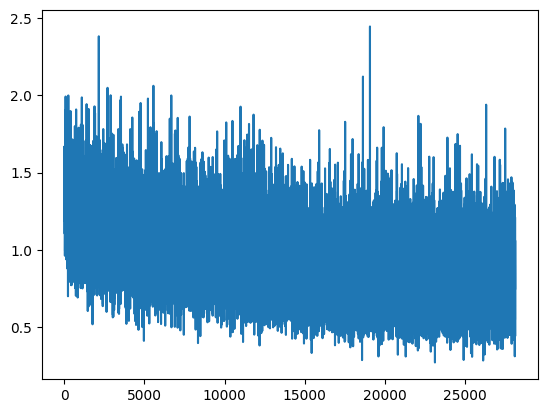

In [25]:
plt.plot(train_losses)

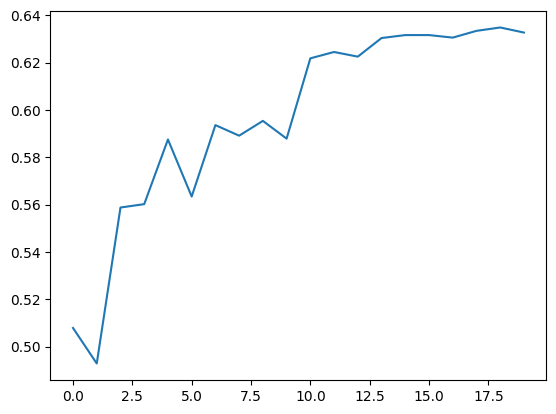

In [26]:
plt.plot(test_accuracy)

In [27]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3539/5600 (0.6320)
{'acc_detail': tensor([0.7364, 0.6700, 0.6571, 0.4643], device='cuda:0'),
 'acc_unweighted': tensor(0.6320, device='cuda:0'),
 'acc_weighted': tensor(0.6320, device='cuda:0'),
 'f1s': tensor(0.6295, device='cuda:0'),
 'f1s_detail': tensor([0.6943, 0.6351, 0.6910, 0.4975], device='cuda:0'),
 'precision_detail': tensor([0.6567, 0.6036, 0.7284, 0.5359], device='cuda:0'),
 'recall_detail': tensor([0.7364, 0.6700, 0.6571, 0.4643], device='cuda:0'),
 'rocauc': tensor([0.9044, 0.8746, 0.8978, 0.7985], device='cuda:0'),
 'uar': tensor(0.6320, device='cuda:0'),
 'wap': tensor(0.6311, device='cuda:0')}


tensor([[1031,   56,   43,  270],
        [  69,  938,  216,  177],
        [  80,  284,  920,  116],
        [ 390,  276,   84,  650]], device='cuda:0')

In [28]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m18_best_19epoch.pt
Correct: 3555/5600 (0.6348)
{'acc_detail': tensor([0.6671, 0.7229, 0.6507, 0.4986], device='cuda:0'),
 'acc_unweighted': tensor(0.6348, device='cuda:0'),
 'acc_weighted': tensor(0.6348, device='cuda:0'),
 'f1s': tensor(0.6345, device='cuda:0'),
 'f1s_detail': tensor([0.6842, 0.6500, 0.6886, 0.5151], device='cuda:0'),
 'precision_detail': tensor([0.7023, 0.5904, 0.7311, 0.5328], device='cuda:0'),
 'recall_detail': tensor([0.6671, 0.7229, 0.6507, 0.4986], device='cuda:0'),
 'rocauc': tensor([0.9050, 0.8754, 0.8984, 0.7977], device='cuda:0'),
 'uar': tensor(0.6348, device='cuda:0'),
 'wap': tensor(0.6392, device='cuda:0')}


tensor([[ 934,   74,   51,  341],
        [  41, 1012,  187,  160],
        [  56,  322,  911,  111],
        [ 299,  306,   97,  698]], device='cuda:0')

In [29]:
checkpoint_path = '../models_esd4/esd4_m18_20epoch.ckpt'
torch.save({
    'epoch': 20,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


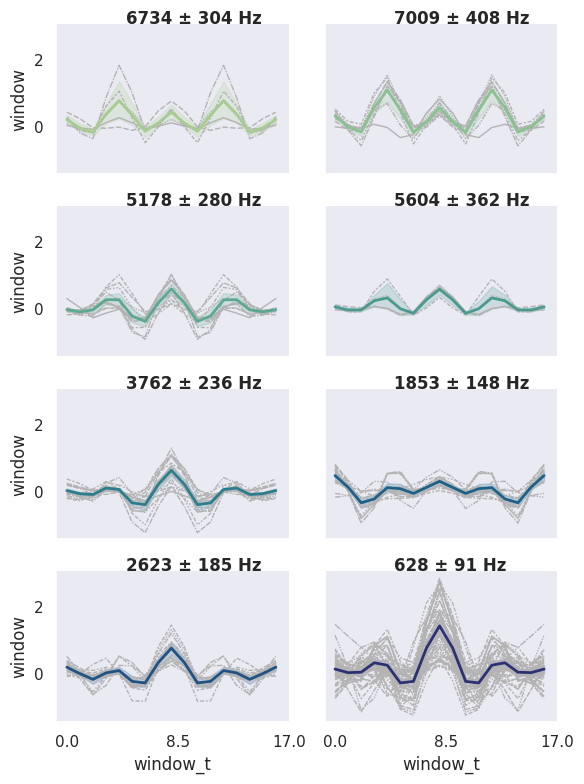

In [31]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


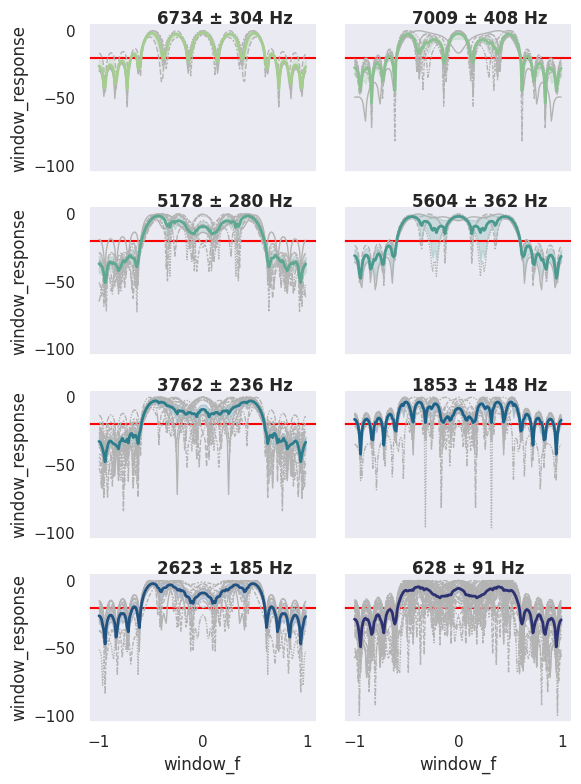

In [32]:
filtviz.visualize_filters(filter_domain='freq')

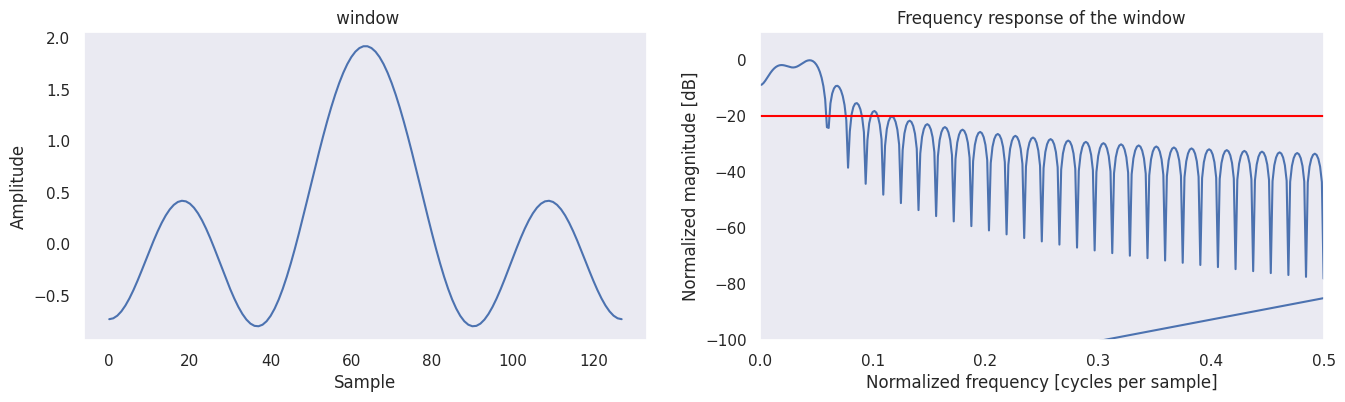

In [33]:
filtviz.visualize_one_window(n_out=10)

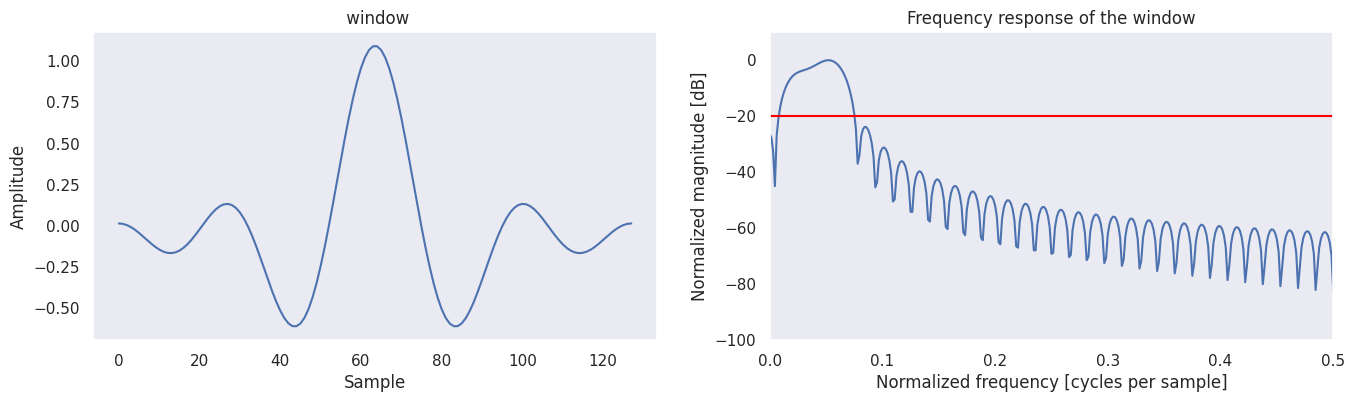

In [34]:
filtviz.visualize_one_window(n_out=30)

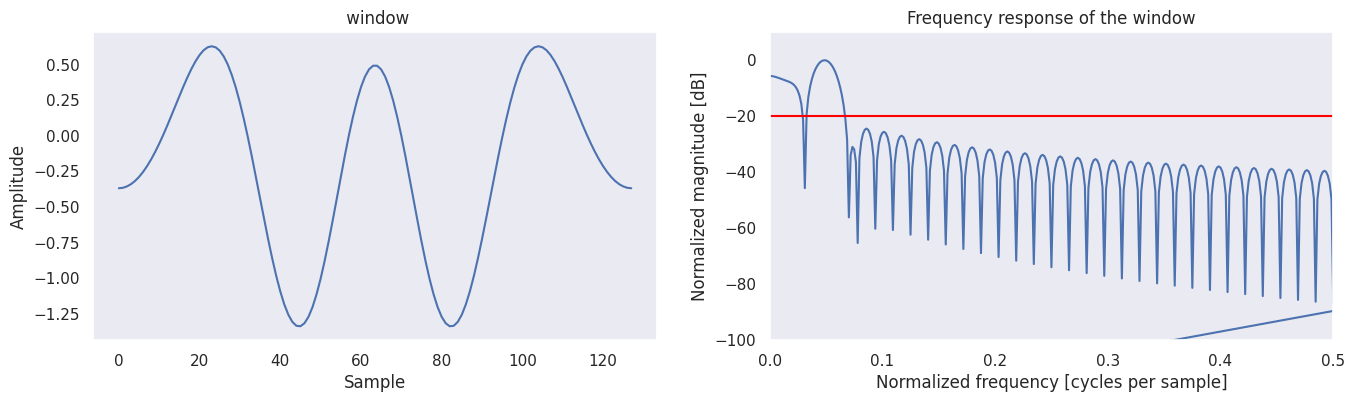

In [35]:
filtviz.visualize_one_window(n_out=50)

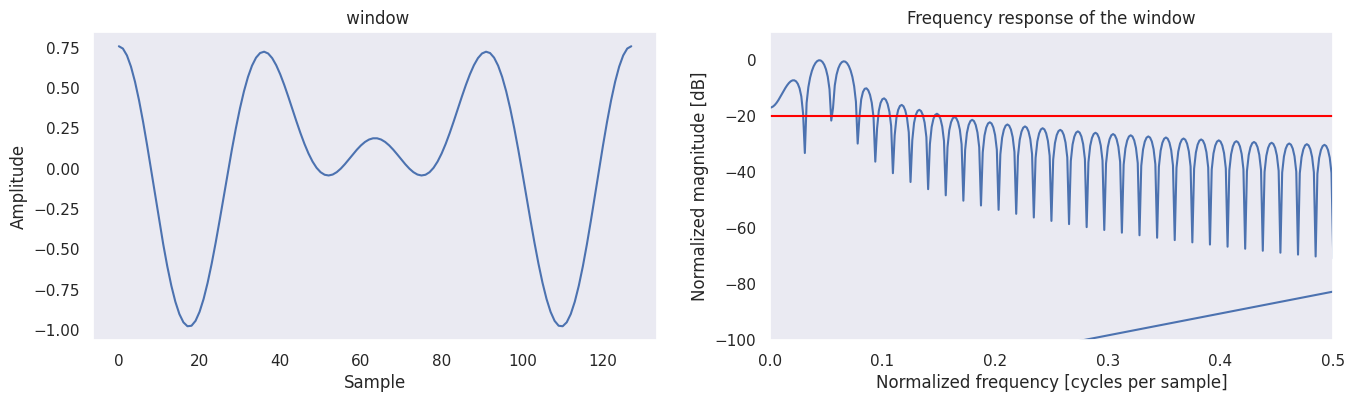

In [36]:
filtviz.visualize_one_window(n_out=60)

In [ ]:
n_epoch = 10
n_epoch2 = 10
n_epoch3 = 100

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.0005714285714285715/100 [00:00<30:03:20, 1082.01s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.779681
Mem before-during-after: 37617152 3516183552 43902464


  0%|                                    | 0.023428571428571413/100 [00:19<21:31:51, 775.30s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 0.794154
Mem before-during-after: 44168704 3521988096 44168704


  0%|                                    | 0.046285714285714215/100 [00:38<20:00:52, 720.86s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.714264
Mem before-during-after: 43928064 3412320256 44504576


  0%|                                     | 0.06914285714285702/100 [00:58<25:17:41, 911.25s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.453966
Mem before-during-after: 44035584 3521897472 43902464


  0%|                                     | 0.09199999999999982/100 [01:17<22:36:58, 814.94s/it]

Train Epoch: 21 [2560/22400 (11%)]	Loss: 0.616767
Mem before-during-after: 44035584 2962840576 43902464


  0%|                                     | 0.11485714285714262/100 [01:35<22:26:39, 808.92s/it]

Train Epoch: 21 [3200/22400 (14%)]	Loss: 0.948196
Mem before-during-after: 43902464 3521764352 43902464


  0%|                                     | 0.13771428571428573/100 [01:51<20:04:56, 723.96s/it]

Train Epoch: 21 [3840/22400 (17%)]	Loss: 1.005617
Mem before-during-after: 44175872 3521632256 43902464


  0%|                                      | 0.1605714285714291/100 [02:10<21:36:49, 779.35s/it]

Train Epoch: 21 [4480/22400 (20%)]	Loss: 0.836670
Mem before-during-after: 44152320 3521928704 44152320


  0%|                                     | 0.18342857142857244/100 [02:28<20:26:43, 737.39s/it]

Train Epoch: 21 [5120/22400 (23%)]	Loss: 1.429131
Mem before-during-after: 43947520 2927909376 44103168


  0%|                                      | 0.2062857142857158/100 [02:47<22:43:33, 819.83s/it]

Train Epoch: 21 [5760/22400 (26%)]	Loss: 0.861552
Mem before-during-after: 43902464 3521631232 44035584


  0%|                                     | 0.22914285714285915/100 [03:07<25:54:50, 935.05s/it]

Train Epoch: 21 [6400/22400 (29%)]	Loss: 1.105539
Mem before-during-after: 44035584 3521764352 44035584


  0%|                                      | 0.2520000000000024/100 [03:25<20:48:21, 750.91s/it]

Train Epoch: 21 [7040/22400 (31%)]	Loss: 0.935513
Mem before-during-after: 43902464 3440713216 44330496


  0%|                                     | 0.27485714285714463/100 [03:44<21:12:13, 765.44s/it]

Train Epoch: 21 [7680/22400 (34%)]	Loss: 1.078510
Mem before-during-after: 43902464 3507503616 43902464


  0%|                                      | 0.2977142857142869/100 [04:04<25:05:29, 906.00s/it]

Train Epoch: 21 [8320/22400 (37%)]	Loss: 0.915885
Mem before-during-after: 44035584 3521897472 43902464


  0%|                                      | 0.3205714285714291/100 [04:24<25:31:33, 921.89s/it]

Train Epoch: 21 [8960/22400 (40%)]	Loss: 0.517862
Mem before-during-after: 44280320 3521875968 44280320


  0%|▏                                    | 0.34342857142857136/100 [04:44<22:38:52, 818.13s/it]

Train Epoch: 21 [9600/22400 (43%)]	Loss: 0.795185
Mem before-during-after: 44035584 3404073472 44249600


  0%|▏                                     | 0.3662857142857136/100 [05:01<21:15:59, 768.41s/it]

Train Epoch: 21 [10240/22400 (46%)]	Loss: 0.743613
Mem before-during-after: 43902464 3522325504 43902464


  0%|▏                                    | 0.38914285714285585/100 [05:20<25:27:37, 920.16s/it]

Train Epoch: 21 [10880/22400 (49%)]	Loss: 0.538222
Mem before-during-after: 44035584 3521897472 43902464


  0%|▏                                     | 0.4119999999999981/100 [05:38<24:14:10, 876.12s/it]

Train Epoch: 21 [11520/22400 (51%)]	Loss: 0.859621
Mem before-during-after: 43902464 3521631232 44035584


  0%|▏                                    | 0.43485714285714033/100 [05:57<25:03:05, 905.79s/it]

Train Epoch: 21 [12160/22400 (54%)]	Loss: 1.076854
Mem before-during-after: 43902464 3521631232 44035584


  0%|▏                                     | 0.4577142857142826/100 [06:16<22:23:19, 809.70s/it]

Train Epoch: 21 [12800/22400 (57%)]	Loss: 0.596749
Mem before-during-after: 43902464 3521828352 43902464


  0%|▏                                     | 0.4805714285714248/100 [06:34<20:36:44, 745.63s/it]

Train Epoch: 21 [13440/22400 (60%)]	Loss: 1.082620
Mem before-during-after: 43902464 3521631232 44035584


  1%|▏                                     | 0.5034285714285671/100 [06:52<23:09:24, 837.86s/it]

Train Epoch: 21 [14080/22400 (63%)]	Loss: 0.487448
Mem before-during-after: 44168704 3521897472 43902464


  1%|▏                                     | 0.5262857142857094/100 [07:11<22:51:23, 827.19s/it]

Train Epoch: 21 [14720/22400 (66%)]	Loss: 0.652006
Mem before-during-after: 44696064 3522216960 43902464


  1%|▏                                     | 0.5491428571428516/100 [07:29<20:44:10, 750.63s/it]

Train Epoch: 21 [15360/22400 (69%)]	Loss: 0.704574
Mem before-during-after: 44035584 3521897472 43902464


  1%|▏                                     | 0.5719999999999938/100 [07:46<22:04:16, 799.14s/it]

Train Epoch: 21 [16000/22400 (71%)]	Loss: 0.880924
Mem before-during-after: 44035584 3307549696 44023296


  1%|▏                                     | 0.5948571428571361/100 [08:03<24:35:00, 890.30s/it]

Train Epoch: 21 [16640/22400 (74%)]	Loss: 0.958200
Mem before-during-after: 44035584 3521764352 44035584


  1%|▏                                     | 0.6177142857142783/100 [08:21<21:49:13, 790.41s/it]

Train Epoch: 21 [17280/22400 (77%)]	Loss: 0.679081
Mem before-during-after: 44168704 3521880064 43902464


  1%|▏                                     | 0.6405714285714206/100 [08:40<20:48:08, 753.71s/it]

Train Epoch: 21 [17920/22400 (80%)]	Loss: 0.901335
Mem before-during-after: 43902464 3521680896 44035584


  1%|▎                                     | 0.6634285714285628/100 [08:58<20:28:53, 742.26s/it]

Train Epoch: 21 [18560/22400 (83%)]	Loss: 0.745592
Mem before-during-after: 43902464 3434067968 44144128


  1%|▎                                     | 0.6862857142857051/100 [09:15<22:02:09, 798.78s/it]

Train Epoch: 21 [19200/22400 (86%)]	Loss: 0.665705
Mem before-during-after: 43902464 3521518592 43902464


  1%|▎                                     | 0.7091428571428473/100 [09:34<23:05:57, 837.51s/it]

Train Epoch: 21 [19840/22400 (89%)]	Loss: 0.808759
Mem before-during-after: 44817920 3522679808 44168704


  1%|▎                                     | 0.7319999999999895/100 [09:53<25:27:01, 922.97s/it]

Train Epoch: 21 [20480/22400 (91%)]	Loss: 0.936498
Mem before-during-after: 43902464 3522328064 43902464


  1%|▎                                     | 0.7548571428571318/100 [10:13<22:33:16, 818.14s/it]

Train Epoch: 21 [21120/22400 (94%)]	Loss: 0.895975
Mem before-during-after: 43902464 3521764352 43902464


  1%|▎                                      | 0.777714285714274/100 [10:33<22:41:13, 823.14s/it]

Train Epoch: 21 [21760/22400 (97%)]	Loss: 1.240189
Mem before-during-after: 44035584 3369267200 43936256


  1%|▍                                     | 0.9999999999999823/100 [12:08<10:32:28, 383.32s/it]


Test Epoch: 21	Accuracy: 3495/5600 (62%)



  1%|▍                                      | 1.000571428571411/100 [12:08<12:39:32, 460.33s/it]

Train Epoch: 22 [0/22400 (0%)]	Loss: 0.845140
Mem before-during-after: 44276224 3522009088 44211200


  1%|▍                                     | 1.0234285714285576/100 [12:24<21:00:30, 764.13s/it]

Train Epoch: 22 [640/22400 (3%)]	Loss: 0.998251
Mem before-during-after: 44249600 3521845248 44249600


  1%|▍                                     | 1.0462857142857043/100 [12:43<20:50:49, 758.43s/it]

Train Epoch: 22 [1280/22400 (6%)]	Loss: 0.566332
Mem before-during-after: 43902464 3521631232 44035584


  1%|▍                                      | 1.069142857142851/100 [12:59<23:46:06, 864.91s/it]

Train Epoch: 22 [1920/22400 (9%)]	Loss: 0.484250
Mem before-during-after: 43902464 3521764352 43902464


  1%|▍                                     | 1.0919999999999976/100 [13:17<20:44:35, 755.00s/it]

Train Epoch: 22 [2560/22400 (11%)]	Loss: 0.598664
Mem before-during-after: 43902464 3521862656 44035584


  1%|▍                                     | 1.1148571428571443/100 [13:36<20:50:48, 758.94s/it]

Train Epoch: 22 [3200/22400 (14%)]	Loss: 1.032858
Mem before-during-after: 44035584 3383456256 44760576


  1%|▍                                      | 1.137714285714291/100 [13:53<20:30:08, 746.58s/it]

Train Epoch: 22 [3840/22400 (17%)]	Loss: 1.050920
Mem before-during-after: 43902464 3522534912 43902464


  1%|▍                                      | 1.160000000000009/100 [14:11<24:39:06, 897.89s/it]

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = '../models_esd4/esd4_m18_120epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)